# EDA
[Link do danych](https://www.kaggle.com/datasets/shubhamgoel27/dermnet)

About Dataset
Context
The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

Content
The images are in JPEG format, consisting of 3 channels, i.e. RGB. The resolutions vary from image to image, and from category to category, but overall these are not extremely high resolution imagery.

The categories include acne, melanoma, Eczema, Seborrheic Keratoses, Tinea Ringworm, Bullous disease, Poison Ivy, Psoriasis, Vascular Tumors, etc.

Acknowledgements
The images are taken from the public portal Dermnet (http://www.dermnet.com/) which is the largest dermatology source online built for the purpose of providing online medical education.

## Loading libraries

In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import cv2
import random
import imageio
import zipfile
import numpy as np
import collections
import pandas as pd
from PIL import Image
import SimpleITK as sitk
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, measure, morphology, data, exposure
from skimage.feature import canny, graycomatrix, graycoprops
from skimage.color import rgb2gray, label2rgb
from skimage.filters import gaussian, threshold_otsu, try_all_threshold
from skimage.segmentation import slic
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle

## Loading the dataset

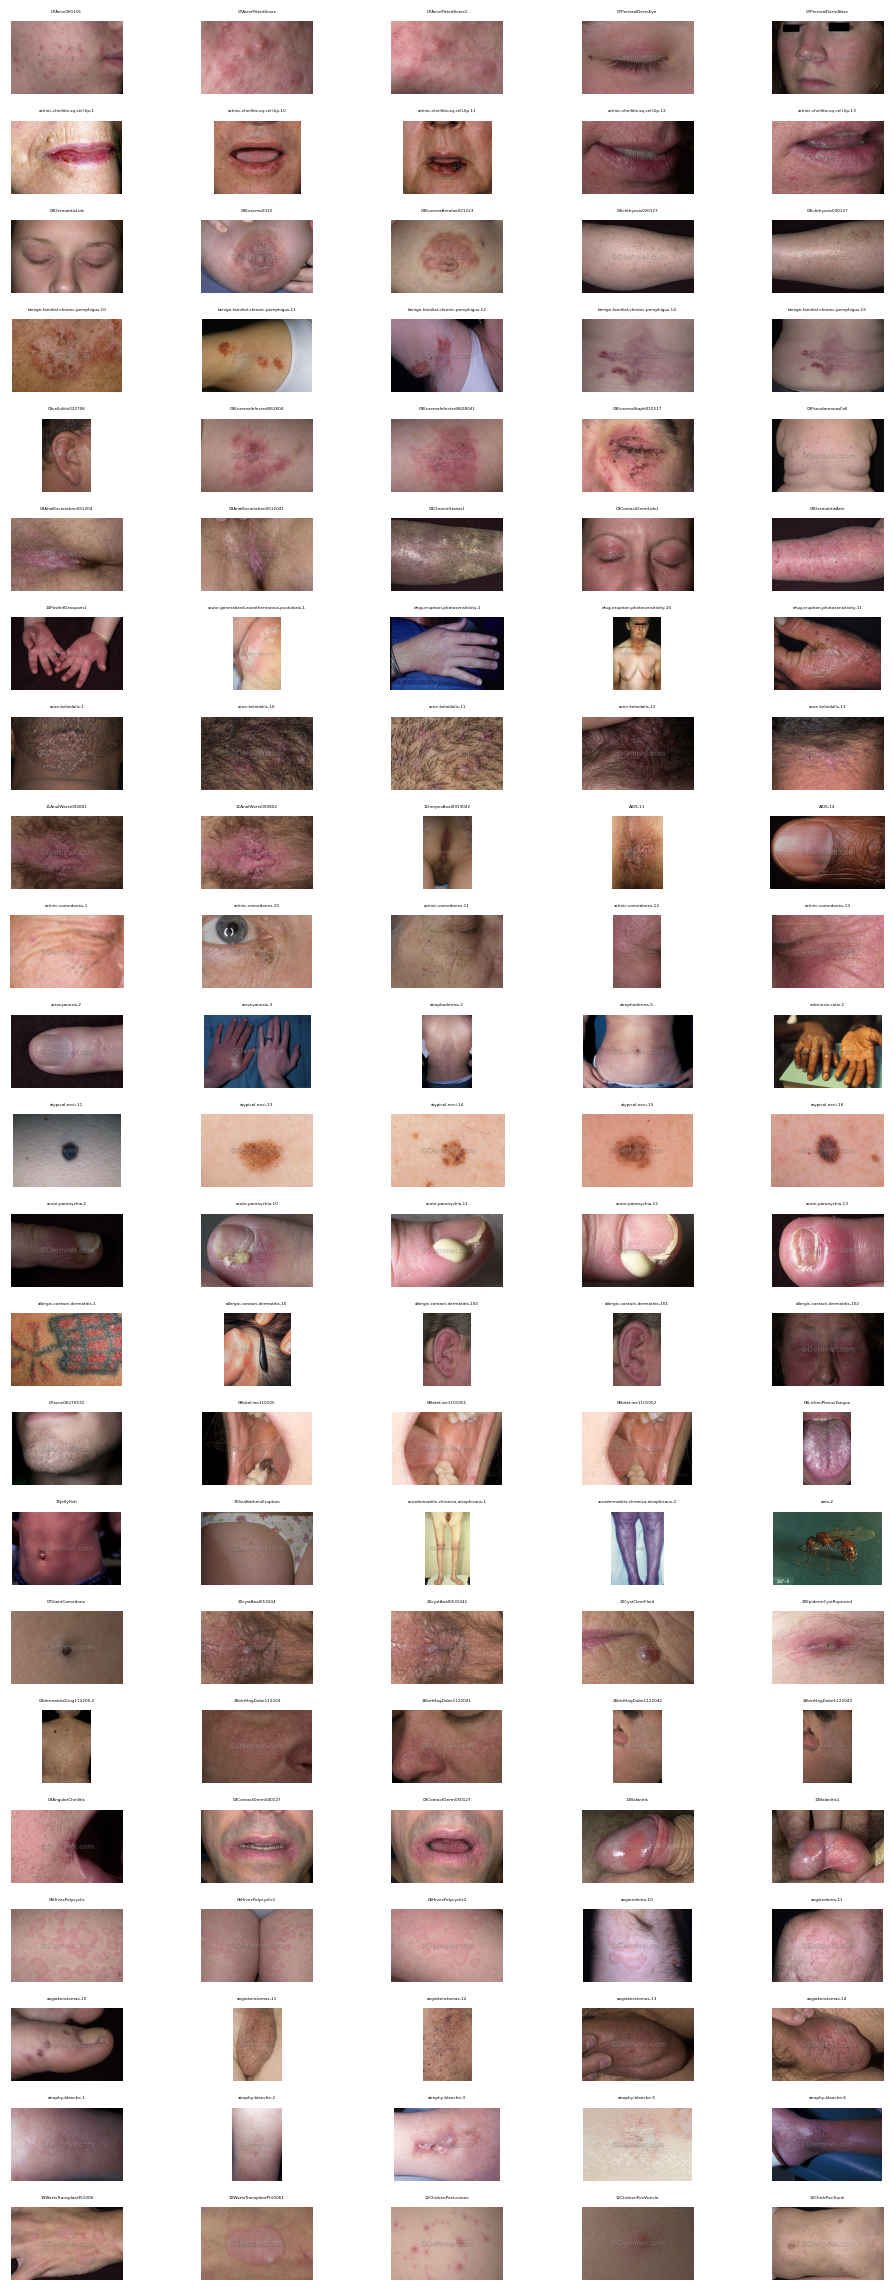

In [2]:
# Setting the path for dataest
dataset_path = '..//Data//train'

# Getting a list of all directories in dataest 
directories_in_dataest = os.listdir(dataset_path)

# Loading and displaying some of the images
directories = len(directories_in_dataest)
samples_from_direcotry = 5
fig, axes = plt.subplots(directories, samples_from_direcotry, figsize=(10, directories))

# Getting all image filenames from found directories
image_files = []
for i, directory in enumerate(directories_in_dataest[:directories]):
    for j, img_file in enumerate(os.listdir(f'{dataset_path}//{directory}')[:samples_from_direcotry]):
        image_files.append(img_file)
        image_path = f'{dataset_path}//{directory}'
        img = Image.open(os.path.join(image_path, img_file))
        axes[i][j].imshow(img)
        axes[i][j].set_title(img_file.split('.')[0])
        axes[i][j].title.set_size(3)
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

## Used functions

In [3]:
analysis = {}
######### potrzebne funkcje:
def show_image(im):
    plt.imshow(im, cmap = 'gray')
    plt.axis('off')
    plt.title('Image')
    plt.show()
def show_images_side_by_side(image1, image2, image3, image4 = None, t1 = None, t2 = None, t3 = None, t4 = None):
    num_images = 3 if image4 is None else 4
    
    fig, axes = plt.subplots(1, num_images, figsize=(12, 6))
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title(t1)
    axes[0].axis('off')
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title(t2)
    axes[1].axis('off')
    axes[2].imshow(image3, cmap='gray')
    axes[2].set_title(t3)
    axes[2].axis('off')
    if image4 is not None:
        axes[3].imshow(image4, cmap='gray')
        axes[3].set_title(t4)
        axes[3].axis('off')
    plt.tight_layout()
def plot_featurest(c, e, co, h):
    fig, axes = plt.subplots(1, 4, figsize=(16, 6))
    axes[0].hist(c, bins = 90)
    axes[0].set_title("Constrast")
    axes[1].hist(e, bins = 90)
    axes[1].set_title("Energy")
    axes[2].hist(co, bins = 90)
    axes[2].set_title("Correlation")
    axes[3].hist(h, bins = 90)
    axes[3].set_title("Homogeneity")
    plt.show()
def plot_side_by_side(plot1, plot2, plot3):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(plot1)
    axes[0].axis('off')
    axes[1].imshow(plot2)
    axes[1].axis('off')
    axes[2].imshow(plot3)
    axes[2].axis('off')
    plt.show()
def histogramy_kanalow_kolorow(images):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    for i in range(len(images)):
        x = 0
        y = i
        red_channel = images[i][:, :, 0]
        green_channel = images[i][:, :, 1]
        blue_channel = images[i][:, :, 2]
        if i == 3 or i == 4 or i == 5:
            x = 1
            y = i - 3
        axes[x, y].hist(red_channel.flatten(), bins=256, color='red', alpha=0.5, label='Czerwony')
        axes[x, y].hist(green_channel.flatten(), bins=256, color='green', alpha=0.5, label='Zielony')
        axes[x, y].hist(blue_channel.flatten(), bins=256, color='blue', alpha=0.5, label='Niebieski')
        axes[x, y].set_title('Histogramy kanałów kolorów')
        axes[x, y].set_xlabel('Wartość piksela')
        axes[x, y].set_ylabel('Liczebność pikseli')
    plt.tight_layout()
    plt.show()
def calculate_color_usage(images): ### lista
    colors = []
    for image in images:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist_hue = cv2.calcHist([hsv], [0], None, [180], [0, 180])
        colors.append(hist_hue)
    return colors
def plot_color_usage(hist_hue):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(len(hist_hue)):
        x = 0
        y = i
        if i == 3 or i == 4 or i == 5:
            x = 1
            y = i - 3
        axes[x, y].plot(hist_hue[i], color='blue')
        axes[x, y].set_xlabel('Wartość barwy (Hue)')
        axes[x, y].set_ylabel('Liczebność pikseli')
        axes[x, y].set_title('Histogram wartości barwy')
    
    plt.tight_layout()
    plt.show()
def color_analysis(images):
    l = []
    for image in images:
        mean_color = np.mean(image, axis=(0, 1))
        std_color = np.std(image, axis=(0, 1))
        l.append((mean_color, std_color))
    color = []
    red = []
    green = []
    blue = []
    for i in range(len(l)):
        color.append(l[i][0])
    for i in range(len(color)):
        red.append(color[i][0])
        green.append(color[i][1])
        blue.append(color[i][2])
    plt.hist(red, bins = 90, color = 'red', alpha = 0.5)
    plt.hist(green, bins = 90, color = 'green', alpha = 0.5)
    plt.hist(blue, bins = 90, color = 'blue', alpha = 0.5)
    plt.show()
    return l
def plot_intensity_histogram(images):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(len(images)):
        x = 0
        y = i
        if i == 3 or i == 4 or i == 5:
            x = 1
            y = i - 3
        sitk_image = sitk.GetImageFromArray(images[i])
        axes[x, y].hist(sitk.GetArrayViewFromImage(sitk_image).flatten(), bins=100)
        axes[x, y].set_title('Histogram intensywności')
        axes[x, y].set_xlabel('Wartość piksela')
        axes[x, y].set_ylabel('Liczebność pikseli')
    plt.tight_layout()
    plt.show()
def intensity_analysis(images):
    l = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mean_intensity = np.mean(gray_image)
        std_intensity = np.std(gray_image)
        l.append(mean_intensity)
    return l
def brightness_differences(images):
    l = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
        brightness_diff = np.mean(laplacian)
        l.append(brightness_diff)
    return l
def object_detection(images):
    l = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        object_count = len(contours)
        l.append(object_count)
    return l
def plot_intensity_brightness_object(i, b, d):
    fig, axes = plt.subplots(1, 3, figsize=(16, 8))
    axes[0].hist(i, bins = 90)
    axes[0].set_title("Intensity")
    axes[1].hist(b, bins = 90)
    axes[1].set_title("Brightness")
    axes[2].hist(d, bins = 90)
    axes[2].set_title("Object Detection")
    plt.show()
def glcm_features(images):
    l = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        glcm = greycomatrix(gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = greycoprops(glcm, 'contrast')[0, 0]
        energy = greycoprops(glcm, 'energy')[0, 0]
        correlation = greycoprops(glcm, 'correlation')[0, 0]
        homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
        l.append((contrast, energy, correlation, homogeneity))
    return l
def otsu_threshold(im):
    img = rgb2gray(im)
    thresh = threshold_otsu(img)
    binary = img > thresh
    return binary
def all_threshold(im):
    grayscale = rgb2gray(im)
    fig, ax = try_all_threshold(grayscale, verbose=False)
    plt.show()
def gaussh(im):
    gaussian_image = gaussian(im, multichannel = True)
    return gaussian_image
def segmenth(im):
    segments = slic(im, n_segments= 400)
    segmented_image = label2rgb(segments, im, kind='avg')
    return segmented_image
def add_noise(im):
    noisy_image = random_noise(im)
    denoised_image = denoise_tv_chambolle(noisy_image, multichannel=True)
    return denoised_image
def can(im):
    img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    canny_edges = canny(img)
    edges_1_8 = canny(img, sigma=1.8)
    edges_2_2 = canny(img, sigma=2.2)
    return canny_edges, edges_1_8, edges_2_2
def ndii(im):
    hist, bins = np.histogram(im.flatten(), bins=256, range=[0, 255])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 6))
    axes[0].plot(bins[:-1], hist, label='Histogram')
    axes[0].set_title('Histogram')
    axes[0].set_ylabel('Frequency')
    axes[1].plot(bins[:-1], cdf_normalized, label='CDF')
def extract_features(images):
    l = []
    for image in images:
        sitk_image = sitk.GetImageFromArray(image)
        statistics = sitk.StatisticsImageFilter()
        statistics.Execute(sitk_image)
        srednia_wartosc_piksela = statistics.GetMean()
        odchylenie = statistics.GetSigma()
        l.append(srednia_wartosc_piksela)
    return l

## Data analysis

### Category counts

Urticaria Hives: 1.36%
Hair Loss Photos Alopecia and other Hair Diseases: 1.54%
Poison Ivy Photos and other Contact Dermatitis: 1.67%
Cellulitis Impetigo and other Bacterial Infections: 1.85%
Exanthems and Drug Eruptions: 2.60%
Herpes HPV and other STDs Photos: 2.60%
Vasculitis Photos: 2.67%
Lupus and other Connective Tissue diseases: 2.70%
Scabies Lyme Disease and other Infestations and Bites: 2.77%
Bullous Disease Photos: 2.88%
Melanoma Skin Cancer Nevi and Moles: 2.98%
Vascular Tumors: 3.10%
Atopic Dermatitis Photos: 3.14%
Light Diseases and Disorders of Pigmentation: 3.65%
Systemic Disease: 3.90%
Acne and Rosacea Photos: 5.40%
Nail Fungus and other Nail Disease: 6.69%
Warts Molluscum and other Viral Infections: 6.98%
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 7.39%
Eczema Photos: 7.94%
Tinea Ringworm Candidiasis and other Fungal Infections: 8.36%
Seborrheic Keratoses and other Benign Tumors: 8.81%
Psoriasis pictures Lichen Planus and related diseases: 9.03%

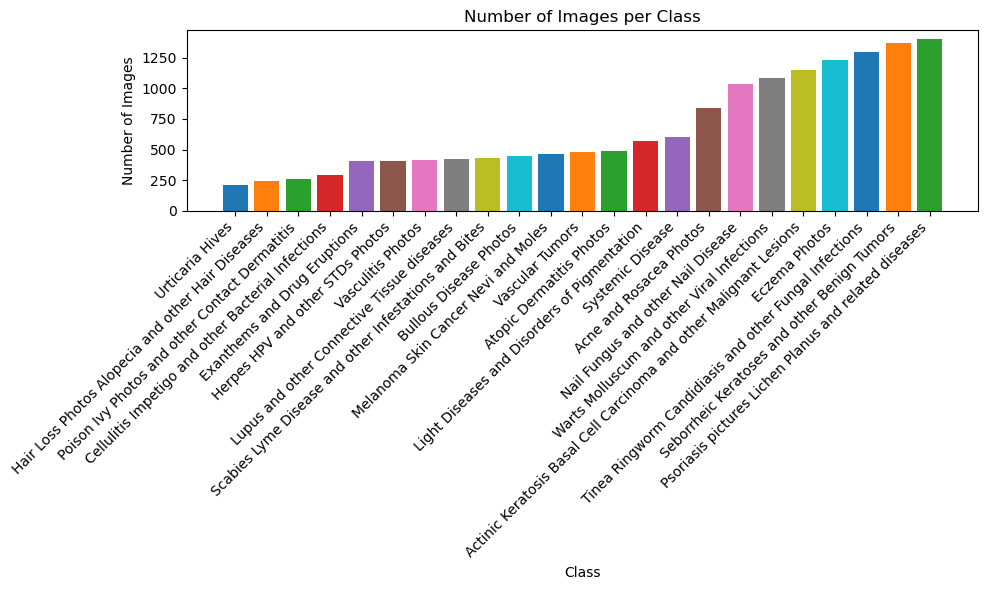

In [4]:
class_image_count = {}

total_images = 0
for directory in directories_in_dataest:
    class_images_path = os.path.join(dataset_path, directory)
    image_count = len(os.listdir(class_images_path))
    class_image_count[directory] = image_count
    total_images += image_count

sorted_class_image_count = dict(sorted(class_image_count.items(), key=lambda item: item[1]))

plt.figure(figsize=(10, 6))
for cls, count in sorted_class_image_count.items():
    percentage = (count / total_images) * 100
    print(f"{cls}: {percentage:.2f}%")
    plt.bar(cls, count)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

wykres przedstawia liczbę zdjęć w różnych klasach chorób skóry. Każda klasa reprezentuje inną chorobę lub stan skóry, a wysokość słupka wskazuje liczbę zdjęć przypisanych do danej klasy.

Największą liczbę zdjęć posiada klasa "Psoriasis pictures Lichen Planus and related diseases" z około 1250 zdjęciami, co stanowi 9,03% wszystkich obrazów.

### Searching for outliers


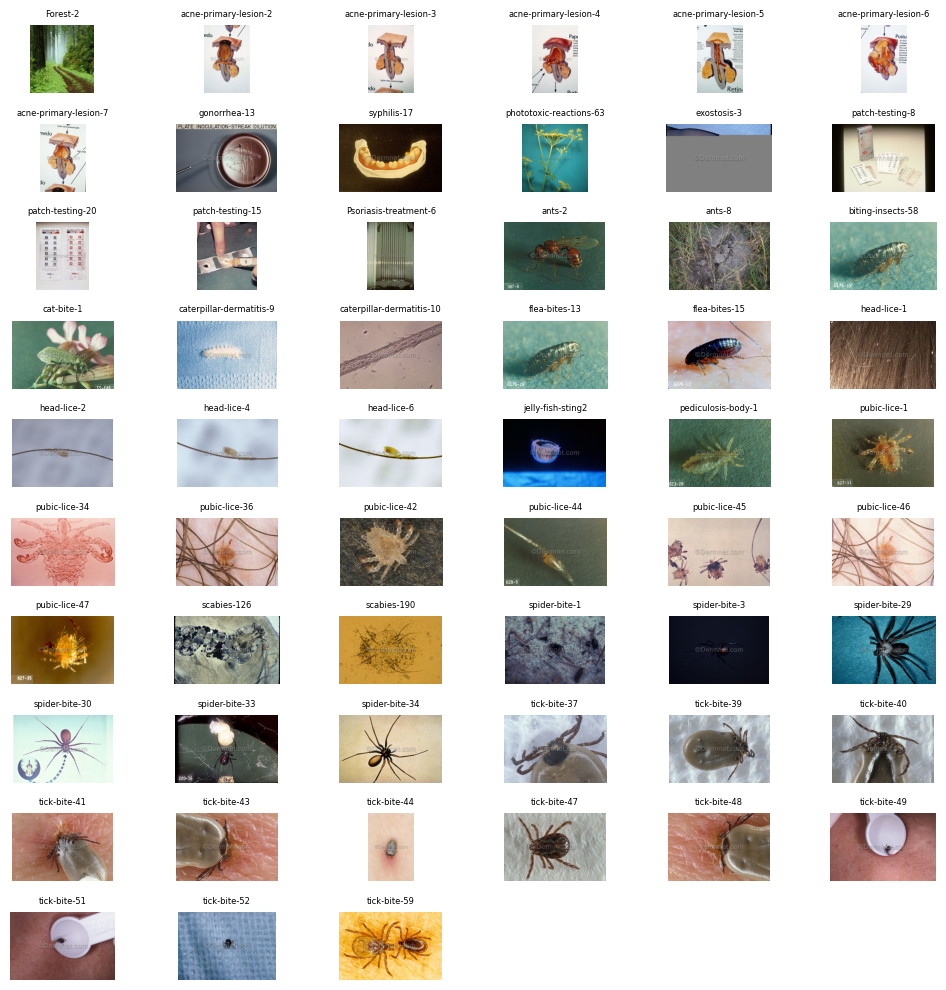

In [5]:
list_of_outliers = [
    # Acne and Rosacea Photos
    'Acne and Rosacea Photos//Forest-2.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-2.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-3.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-4.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-5.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-6.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-7.jpg',
    
    # Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
    
    # Atopic Dermatitis Photos
    
    # Bullous Disease Photos
    
    # Cellulitis Impetigo and other Bacterial Infections
    
    # Eczema Photos
    
    # Exanthems and Drug Eruptions
    
    # Hair Loss Photos Alopecia and other Hair Diseases
    
    # Herpes HPV and other STDs Photos
    'Herpes HPV and other STDs Photos//gonorrhea-13.jpg',
    'Herpes HPV and other STDs Photos//syphilis-17.jpg',
    
    # Light Diseases and Disorders of Pigmentation
    'Light Diseases and Disorders of Pigmentation//phototoxic-reactions-63.jpg',
    
    # Lupus and other Connective Tissue diseases
    
    # Melanoma Skin Cancer Nevi and Moles
    
    # Nail Fungus and other Nail Disease
    'Nail Fungus and other Nail Disease//exostosis-3.jpg',
    
    # Poison Ivy Photos and other Contact Dermatitis
    'Poison Ivy Photos and other Contact Dermatitis//patch-testing-8.jpg',
    'Poison Ivy Photos and other Contact Dermatitis//patch-testing-20.jpg',
    'Poison Ivy Photos and other Contact Dermatitis//patch-testing-15.jpg',
    
    # Psoriasis pictures Lichen Planus and related diseases
    'Psoriasis pictures Lichen Planus and related diseases//Psoriasis-treatment-6.jpg',
    
    # Scabies Lyme Disease and other Infestations and Bites
    'Scabies Lyme Disease and other Infestations and Bites//ants-2.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//ants-8.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//biting-insects-58.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//cat-bite-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//caterpillar-dermatitis-9.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//caterpillar-dermatitis-10.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//flea-bites-13.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//flea-bites-15.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//head-lice-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//head-lice-2.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//head-lice-4.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//head-lice-6.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//jelly-fish-sting2.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pediculosis-body-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-34.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-36.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-42.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-44.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-45.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-46.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-47.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//scabies-126.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//scabies-190.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-3.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-29.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-30.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-33.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-34.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-37.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-39.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-40.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-41.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-43.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-44.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-47.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-48.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-49.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-51.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-52.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-59.jpg'
    
    # Seborrheic Keratoses and other Benign Tumors
    
    # Systemic Disease
    
    # Tinea Ringworm Candidiasis and other Fungal Infections
    
    # Urticaria Hives
    
    # Vascular Tumors
    
    # Vasculitis Photos
    
    # Warts Molluscum and other Viral Infections
]

n_rows = 10
n_cols = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows))
r=0
c=0
for i, outlier in enumerate(list_of_outliers):
    img = Image.open(f'{dataset_path}//{outlier}')
    axes[r][c].imshow(img)
    axes[r][c].set_title(outlier.split('//')[-1].split('.')[0])
    axes[r][c].title.set_size(6)
    axes[r][c].axis('off')
    if (i+1) % n_cols == 0:
        r+=1
        c=-1
    c+=1
for i in range(3, n_cols):
    fig.delaxes(axes[n_rows-1][i])
plt.tight_layout()
plt.show()

### Image dimension analysis


Widths countsCounter({720: 21574, 480: 598, 473: 161, 490: 115, 482: 115, 476: 115, 464: 92, 472: 92, 478: 92, 467: 92, 489: 92, 484: 92, 494: 69, 491: 69, 474: 69, 465: 69, 492: 69, 485: 69, 483: 69, 468: 69, 601: 69, 479: 69, 475: 69, 495: 46, 469: 46, 471: 46, 498: 46, 486: 46, 611: 46, 470: 46, 597: 23, 687: 23, 481: 23, 604: 23, 619: 23, 677: 23, 685: 23, 690: 23, 599: 23, 584: 23, 582: 23, 519: 23, 487: 23, 509: 23, 488: 23, 496: 23, 602: 23, 638: 23, 609: 23, 683: 23, 650: 23, 633: 23, 596: 23, 503: 23, 540: 23, 454: 23, 557: 23, 565: 23, 592: 23})
Heights countsCounter({472: 6279, 720: 3404, 480: 1495, 474: 989, 477: 966, 475: 575, 469: 552, 471: 529, 468: 529, 470: 506, 482: 506, 481: 460, 476: 437, 485: 414, 464: 391, 479: 391, 487: 391, 478: 391, 473: 368, 490: 345, 484: 322, 488: 253, 483: 230, 466: 230, 491: 207, 486: 184, 489: 184, 467: 184, 493: 161, 465: 161, 495: 115, 596: 115, 460: 115, 463: 92, 594: 92, 494: 92, 598: 92, 499: 69, 500: 69, 599: 69, 588: 69, 609: 69, 5

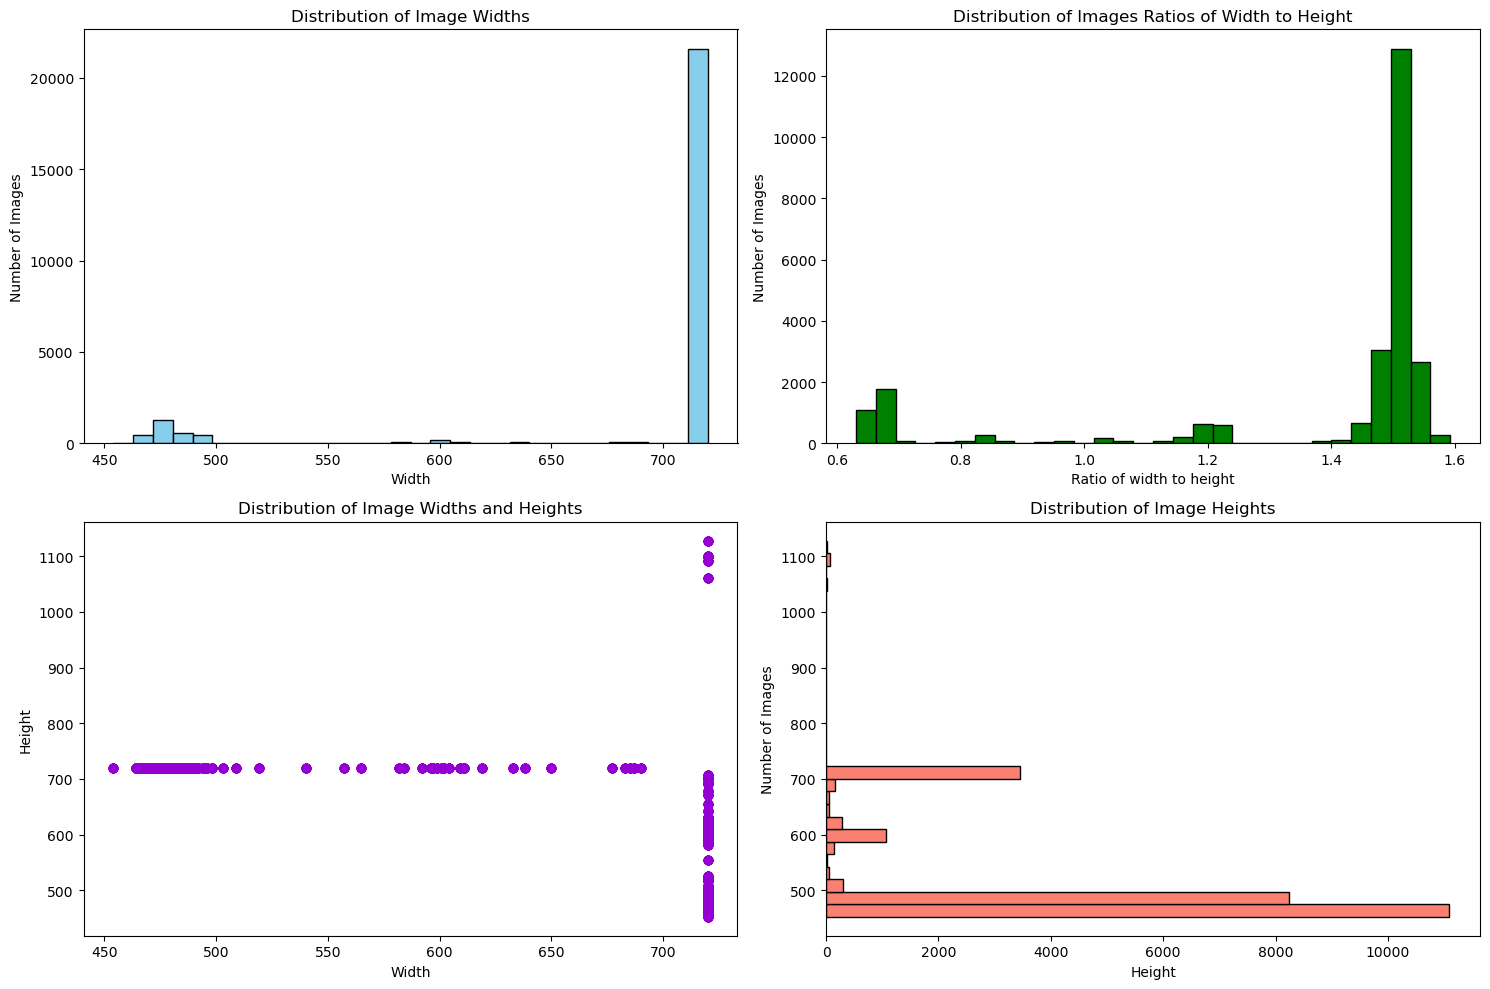

In [6]:
# Extracting dimensions (width and height) of all images
image_dimensions = [Image.open(os.path.join(image_path, img_file)).size 
                    for img_file in os.listdir(f'{dataset_path}//{directory}')
                    for directory in directories_in_dataest]

# Separating widths and heights
widths, heights = zip(*image_dimensions)



def plot_dimensions_distributions(widths, heights):
    
    # Getting sorted counts of each width and length
    widths_counter = collections.Counter(widths)
    print(f'Widths counts{widths_counter}')
    heights_counter = collections.Counter(heights)
    print(f'Heights counts{heights_counter}')

    # Plotting distribution of widths and heights
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # Plotting widths
    ax[0][0].hist(widths, bins=30, color='skyblue', edgecolor='black')
    ax[0][0].set_title('Distribution of Image Widths')
    ax[0][0].set_xlabel('Width')
    ax[0][0].set_ylabel('Number of Images')

    # Plotting ratios of widths to heights
    ratio = [widths[i]/heights[i] for i in range(len(image_dimensions))]
    print(f'Mean of ratios of width to height: {np.mean(ratio)}')
    ax[0][1].hist(ratio, bins=30, color='green', edgecolor='black')
    ax[0][1].set_title('Distribution of Images Ratios of Width to Height')
    ax[0][1].set_xlabel('Ratio of width to height')
    ax[0][1].set_ylabel('Number of Images')

    # Plotting widths and heights
    ax[1][0].scatter(widths, heights, color = 'darkviolet')
    ax[1][0].set_title('Distribution of Image Widths and Heights')
    ax[1][0].set_xlabel('Width')
    ax[1][0].set_ylabel('Height')

    # Plotting heights
    ax[1][1].hist(heights, bins=30, color='salmon', edgecolor='black', orientation='horizontal')
    ax[1][1].set_title('Distribution of Image Heights')
    ax[1][1].set_xlabel('Height')
    ax[1][1].set_ylabel('Number of Images')

    plt.tight_layout()
    plt.show()

plot_dimensions_distributions(widths, heights)

Widths countsCounter({720: 24863, 1101: 23, 1128: 23, 1098: 23, 1060: 23, 1092: 23})
Heights countsCounter({472: 6371, 480: 2093, 474: 1058, 477: 966, 475: 644, 482: 621, 468: 598, 469: 598, 471: 575, 476: 552, 470: 552, 473: 529, 464: 483, 485: 483, 478: 483, 481: 483, 490: 460, 479: 460, 487: 414, 484: 414, 483: 299, 488: 276, 491: 276, 489: 276, 467: 276, 486: 230, 465: 230, 466: 230, 495: 161, 494: 161, 493: 161, 596: 138, 460: 115, 720: 115, 463: 92, 597: 92, 594: 92, 599: 92, 492: 92, 609: 92, 601: 92, 598: 92, 611: 92, 499: 69, 500: 69, 498: 69, 588: 69, 507: 69, 605: 69, 586: 69, 496: 69, 589: 46, 693: 46, 607: 46, 690: 46, 497: 46, 604: 46, 619: 46, 592: 46, 608: 46, 678: 46, 606: 46, 459: 46, 591: 46, 582: 46, 587: 46, 461: 46, 643: 23, 687: 23, 625: 23, 707: 23, 521: 23, 505: 23, 677: 23, 685: 23, 626: 23, 624: 23, 593: 23, 603: 23, 595: 23, 525: 23, 642: 23, 457: 23, 590: 23, 613: 23, 631: 23, 618: 23, 584: 23, 600: 23, 701: 23, 615: 23, 628: 23, 519: 23, 516: 23, 509: 23, 

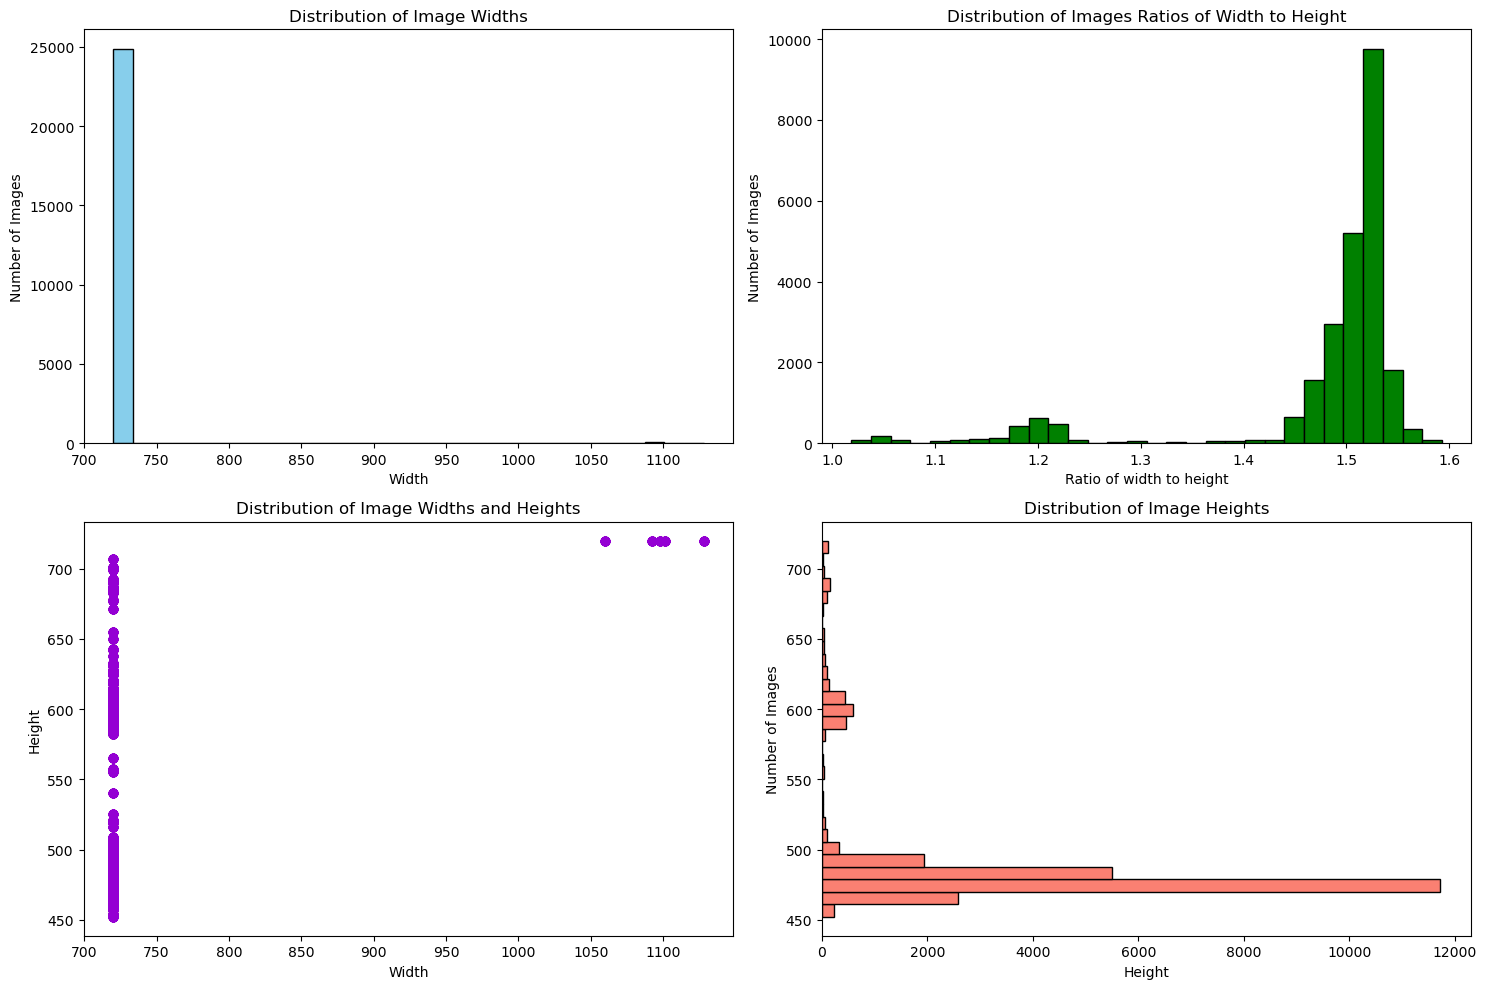

In [7]:
new_widths = [0] * len(image_dimensions)
new_heights = [0] * len(image_dimensions)
for i in range(len(image_dimensions)):
    if heights[i] > widths[i]:
        new_widths[i], new_heights[i] = heights[i], widths[i]
    else:
        new_heights[i], new_widths[i] = heights[i], widths[i]

plot_dimensions_distributions(new_widths, new_heights)

## Analiza kolorów, zdjęć ...

### Acne and Rosacea Photos

In [8]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[0]
images1 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images1.append(image)
last_element = os.path.basename(folder_path)
last_element

'Acne and Rosacea Photos'

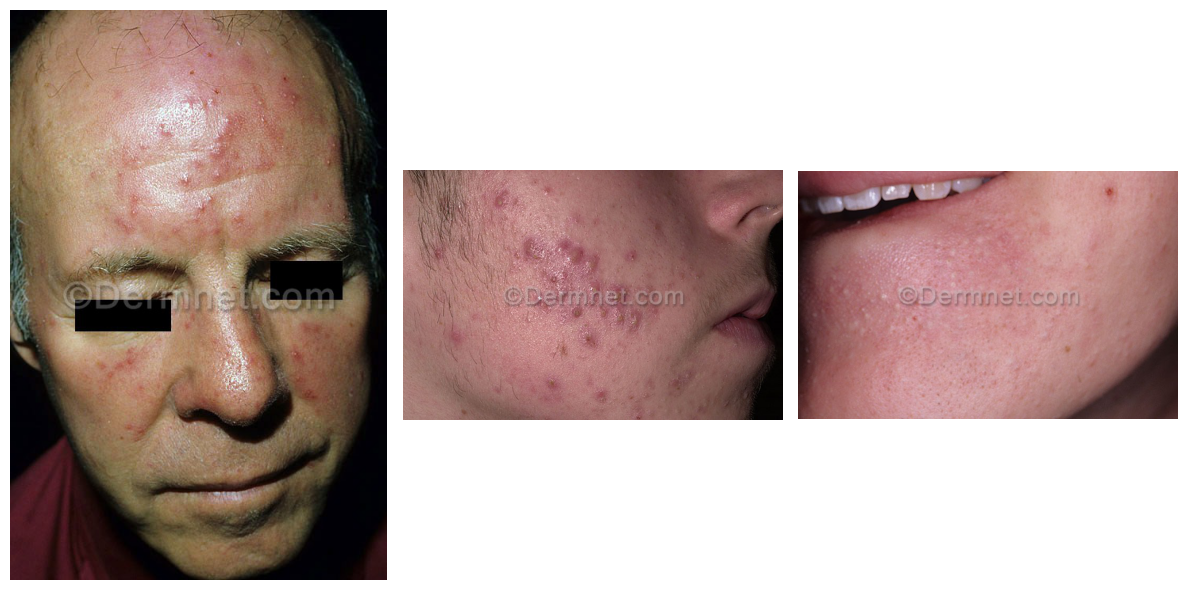

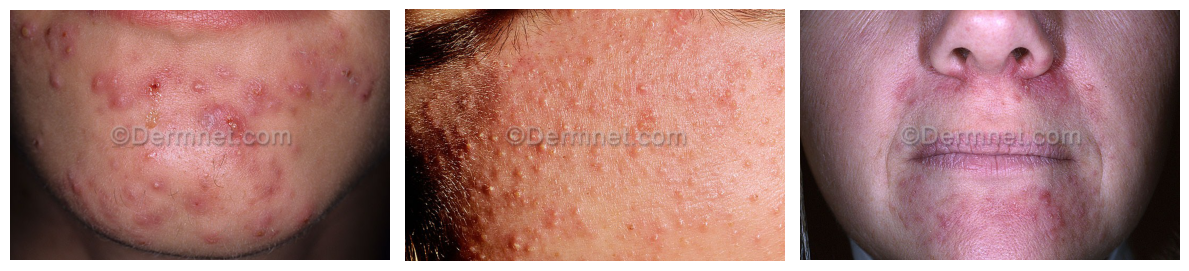

In [9]:
### przykładowe obrazy z kategorii (6)
selected_images1 = random.sample(images1, 6)
show_images_side_by_side(selected_images1[0], selected_images1[1], selected_images1[2])
show_images_side_by_side(selected_images1[3], selected_images1[4], selected_images1[5])

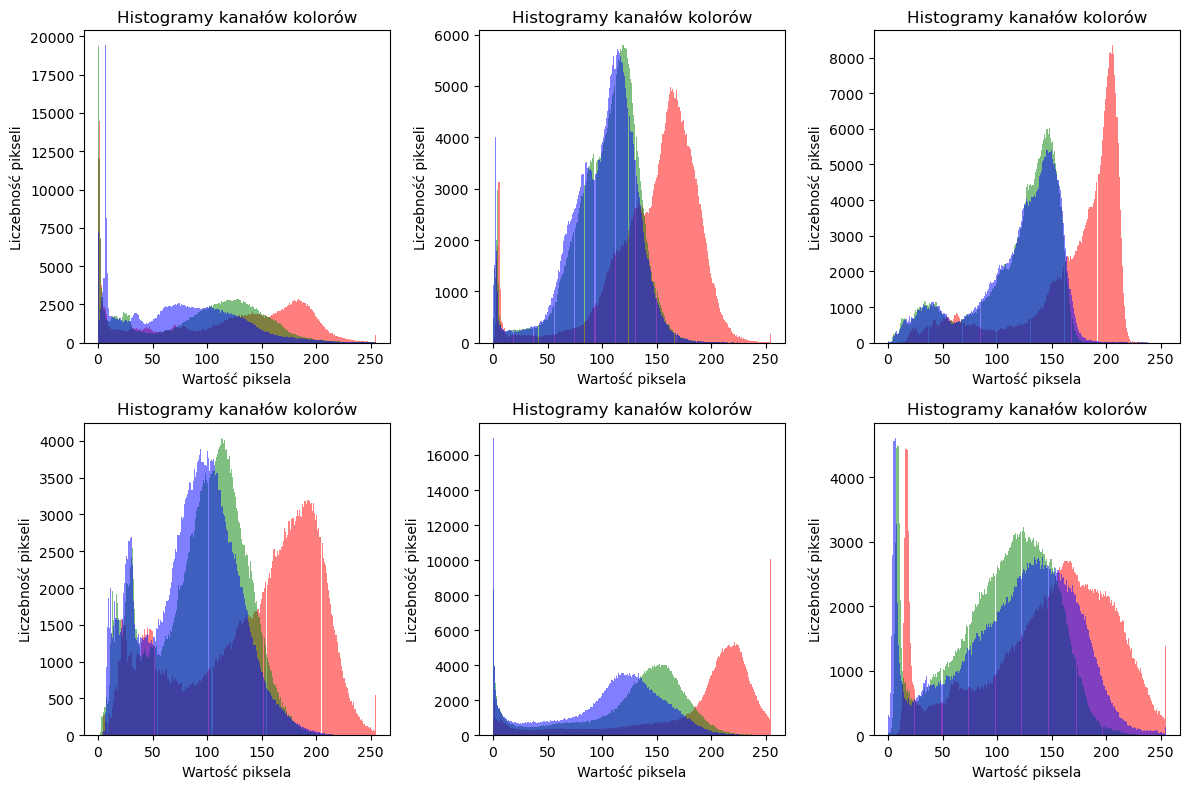

In [10]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images1)

Wszystkie zdjęcia są w odcieniach beżu, ale w rozkładzie na 3 kolory nie widać 
podobieństw

In [12]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images1)):
    thr = otsu_threshold(selected_images1[i])
    gauss = gaussh(selected_images1[i])
    segment = segmenth(selected_images1[i])
    noise = add_noise(selected_images1[i])
    show_images_side_by_side(thr, gauss, segment, noise)

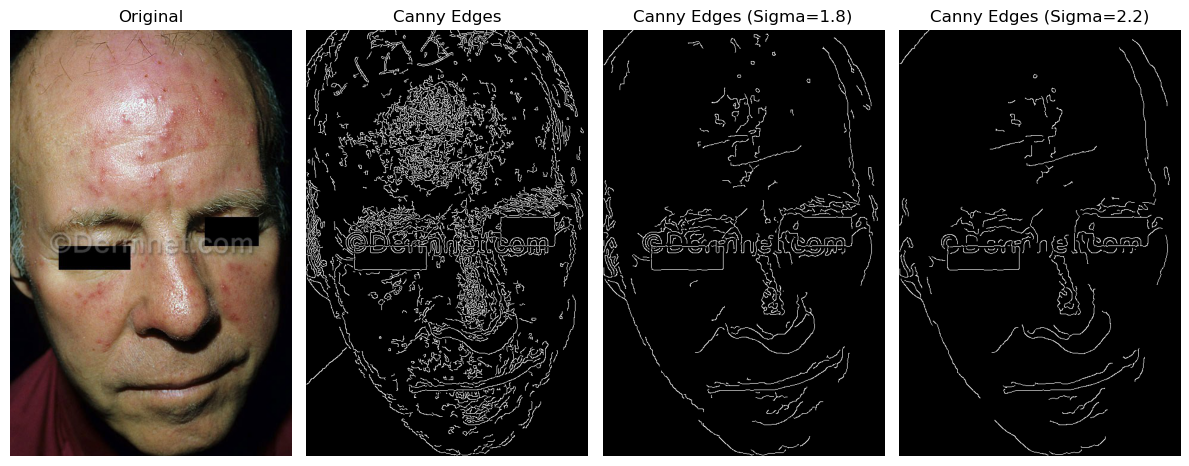

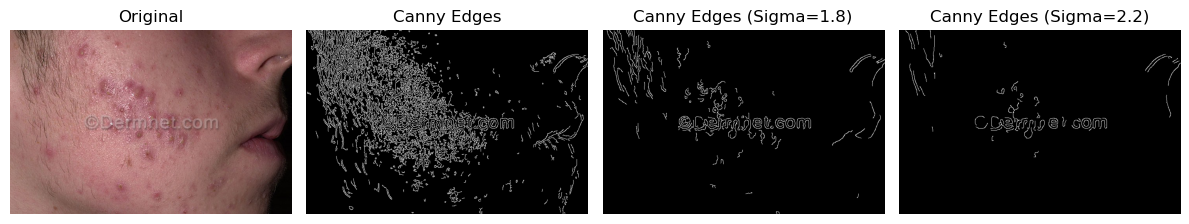

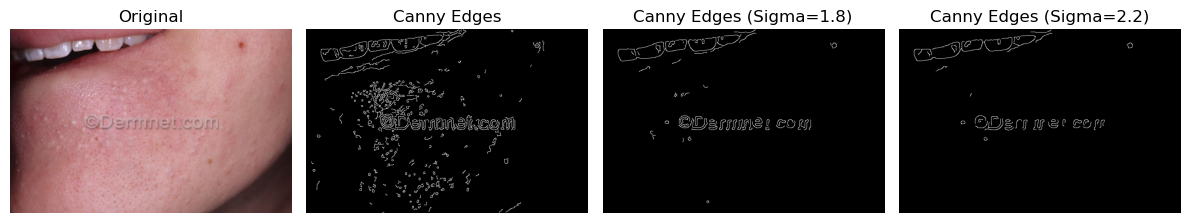

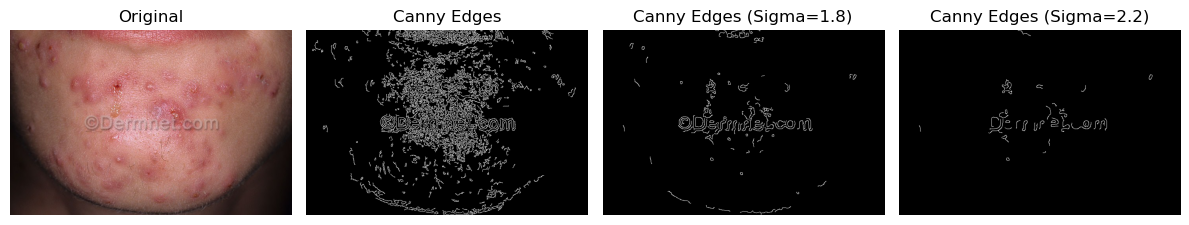

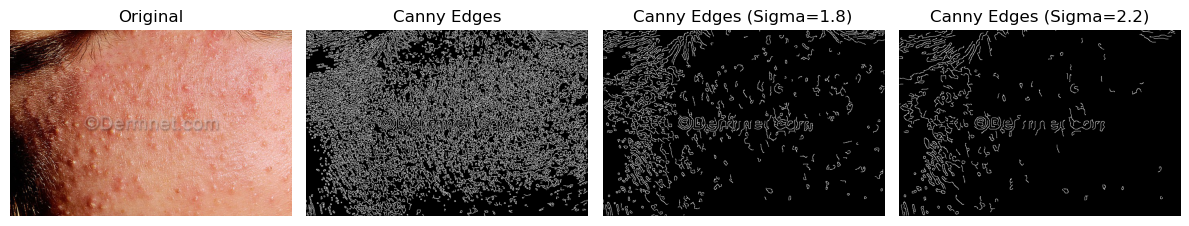

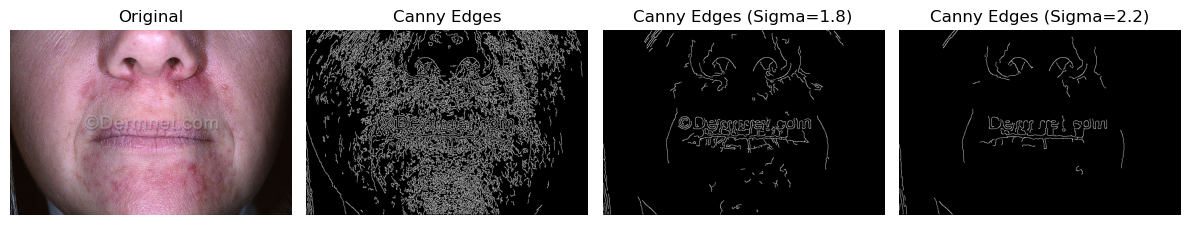

In [13]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images1)):
    c, c1, c2 = can(selected_images1[i])
    show_images_side_by_side(selected_images1[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

Bardzo dużo krawędzi -> ma to sens, ponieważ są to zdjęcia trądziku

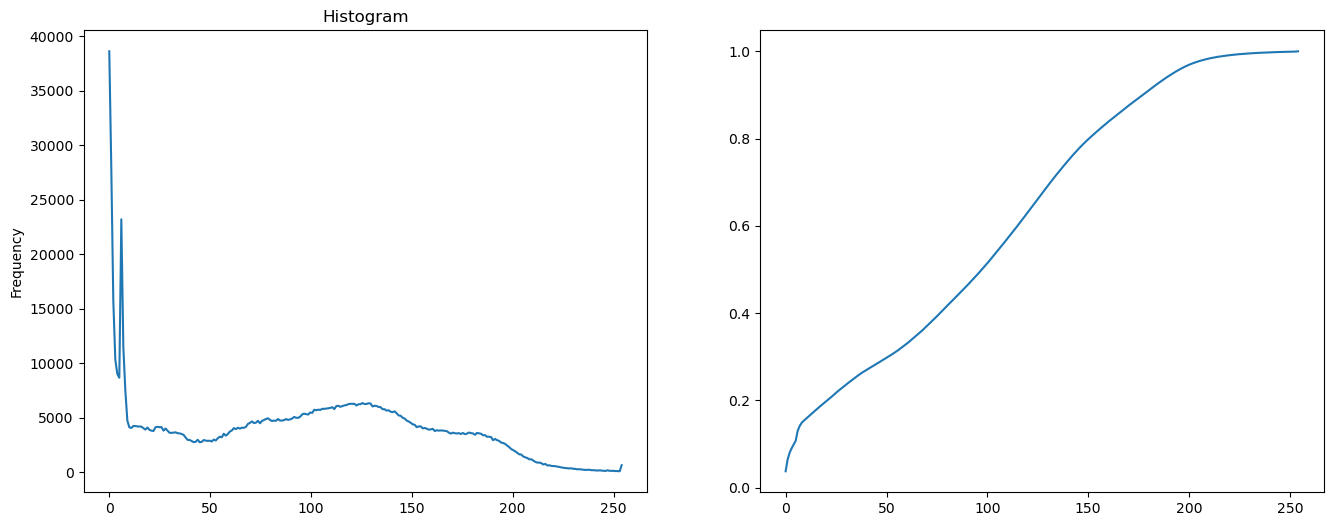

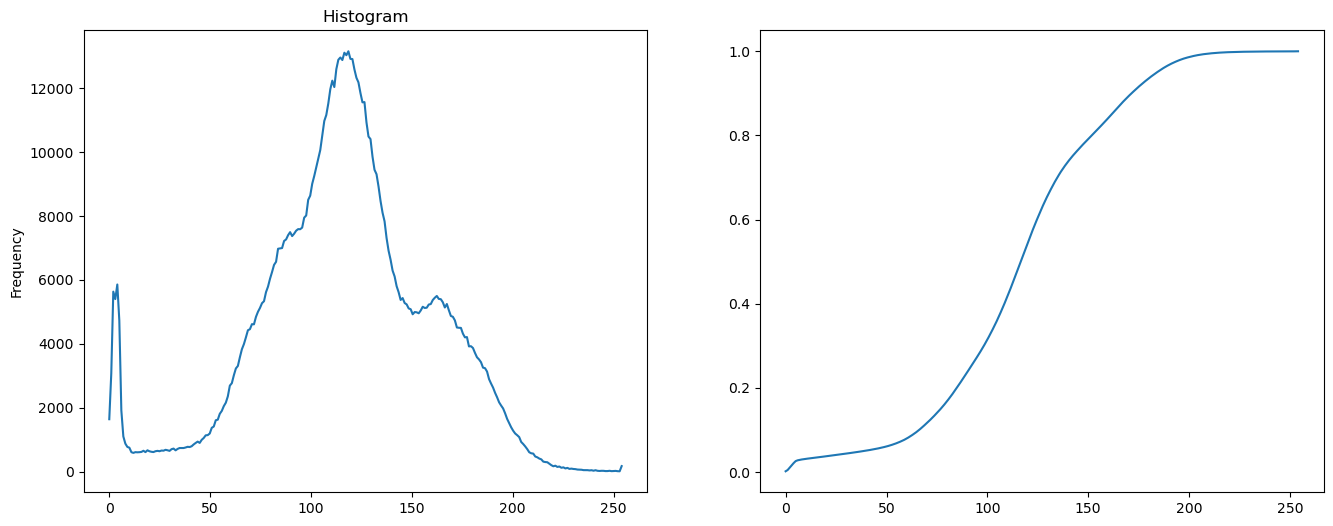

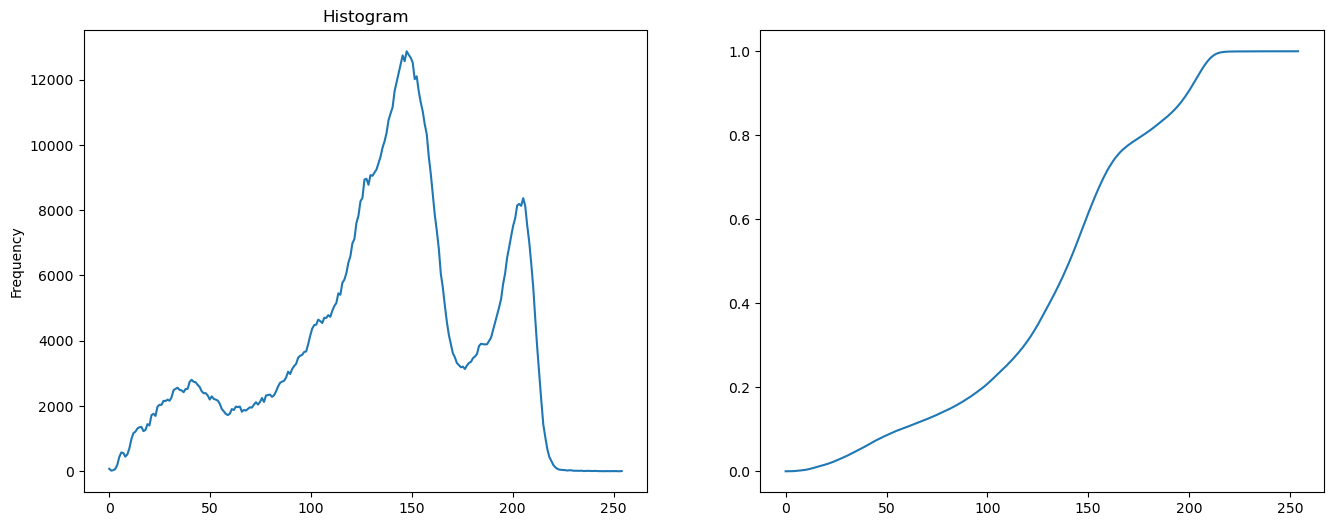

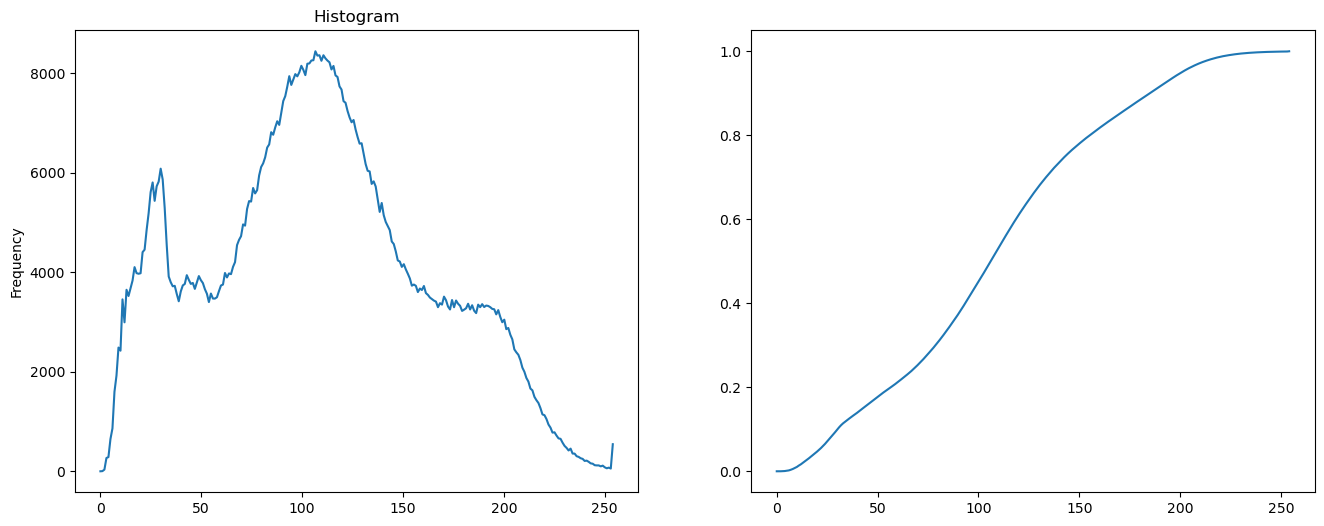

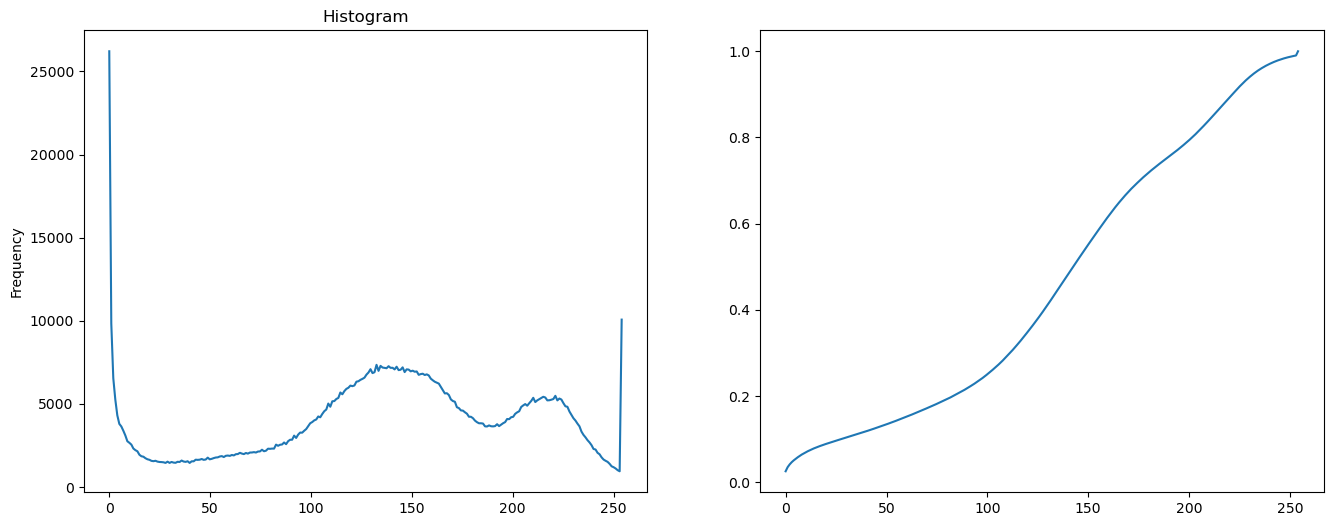

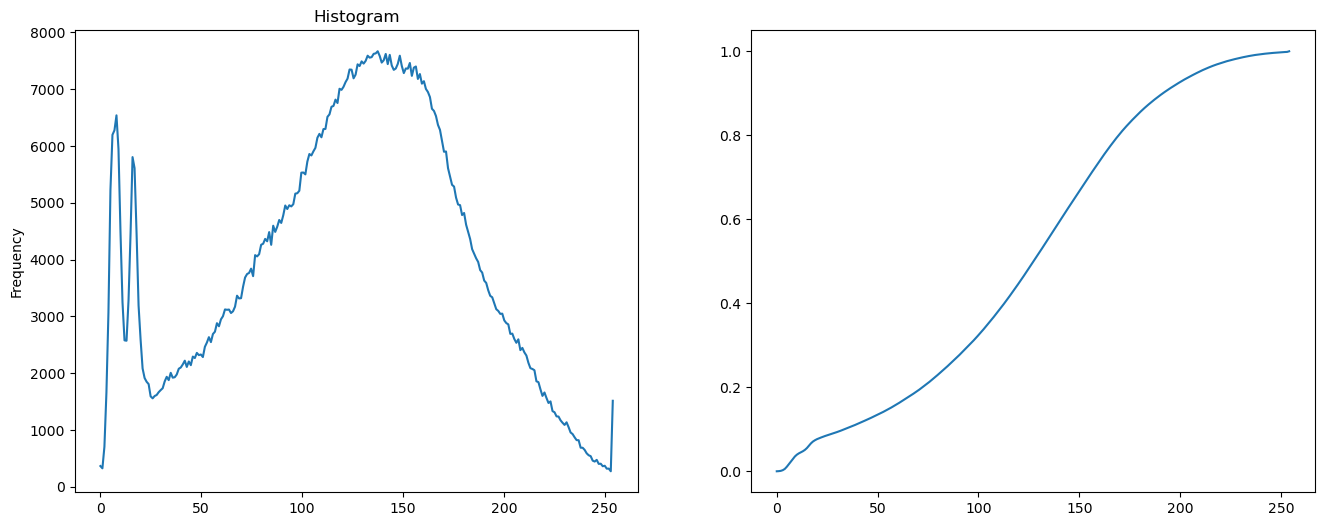

In [14]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images1)):
    ndii(selected_images1[i])

 wartość piksela w zakresie [0, 255] jest podstawową reprezentacją intensywności koloru w obrazach 8-bitowych, gdzie 0 oznacza brak intensywności (czarny), a 255 maksymalną intensywność (biały lub pełny kolor w przypadku RGB). WYkres po lewej stronie to histogram rozkładu intensywności. Natomiast po prawej odpowiadająca mu dystrybuanta


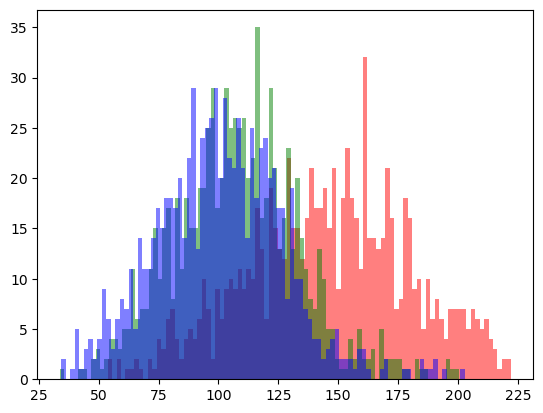

In [15]:
### mean, sd colors 
l = color_analysis(images1)

Funkcja color_analysis analizuje listę obrazów, obliczając średnią i odchylenie standardowe kanałów kolorów dla każdego obrazu. Następnie wyświetla histogramy dla czerwonych, zielonych i niebieskich składników kolorów średnich dla wszystkich obrazów.

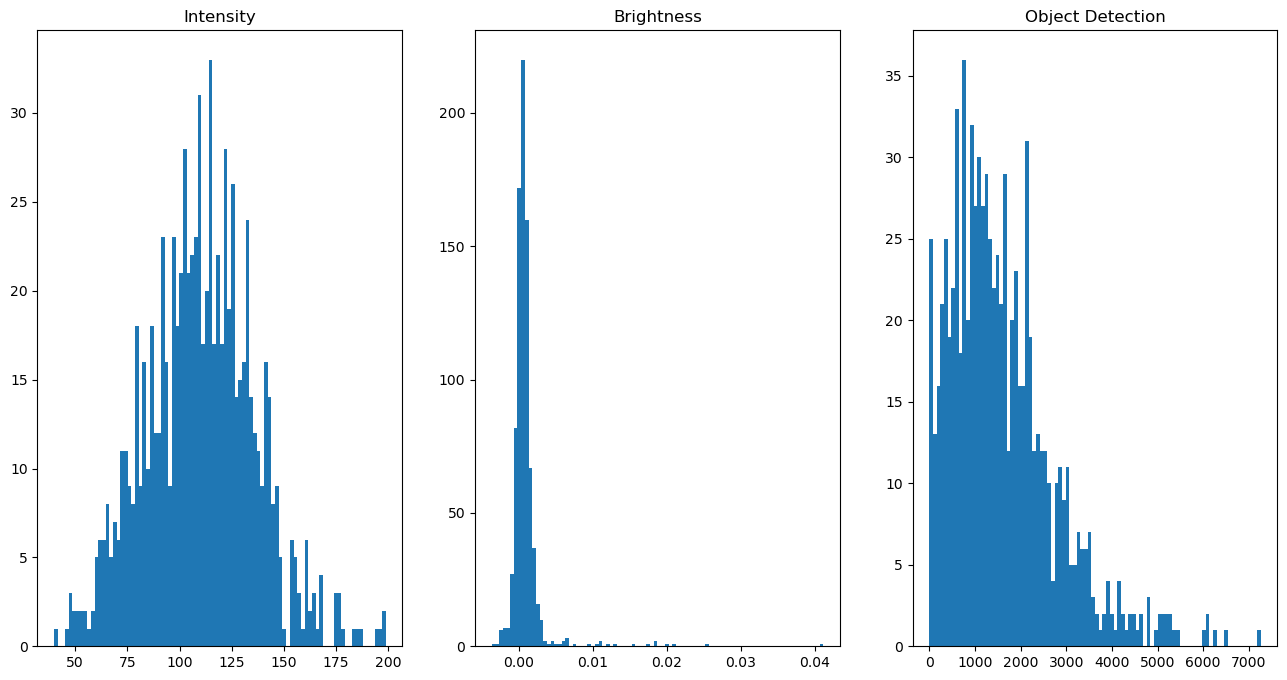

NameError: name 'greycomatrix' is not defined

In [16]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images1)
brightness = brightness_differences(images1)
objects = object_detection(images1)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images1)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[0]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

intensity_analysis(images)
Co robi ta funkcja:
Analizuje listę obrazów, przekształca je na obrazy w skali szarości i oblicza średnią intensywność oraz odchylenie standardowe intensywności dla każdego obrazu. Histogram na osi y ma ilość zdjęć, a na osi x średnią intensywaność dla zdjęcia

brightness: Analizuje listę obrazów, przekształca je na obrazy w skali szarości, wygładza je za pomocą rozmycia Gaussa i oblicza średnią różnicę jasności 

objects: Analizuje listę obrazów, przekształca je na obrazy w skali szarości, binarizuje je i liczy kontury obiektów na każdym obrazie.

Funkcje te analizują różne aspekty obrazów: intensywność (średnia intensywność pikseli), różnice jasności (średnia różnica jasności pikseli) oraz liczba obiektów (liczba konturów wykrytych w obrazie). Następnie wyniki te są przedstawiane na histogramach, aby wizualnie ocenić rozkład analizowanych cech.

Contrast (Kontrast):

Histogram dla kontrastu pokazuje, że większość obrazów ma stosunkowo niski kontrast, co oznacza, że różnice w intensywnościach pikseli w większości obrazów są niewielkie

Energy (Energia):

Histogram dla energii pokazuje, że większość obrazów ma niską wartość energii, co sugeruje, że wiele obrazów ma zróżnicowaną teksturę.

Correlation (Korelacja):

Histogram dla korelacji pokazuje, że większość obrazów ma wysokie wartości korelacji, co oznacza, że piksele w tych obrazach są silnie skorelowane, czyli uporządkowane.


Histogram pokazuje, że większość obrazów w analizowanym zbiorze ma niską jednorodność, co sugeruje, że tekstury w tych obrazach są zróżnicowane. Niskie wartości jednorodności wskazują na dużą różnorodność w intensywnościach sąsiednich pikseli, co jest charakterystyczne dla obrazów z bardziej skomplikowanymi wzorami lub elementami.


### Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[1]
images2 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images2.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images2 = random.sample(images2, 6)
show_images_side_by_side(selected_images2[0], selected_images2[1], selected_images2[2])
show_images_side_by_side(selected_images2[3], selected_images2[4], selected_images2[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images2)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images2)):
    thr = otsu_threshold(selected_images2[i])
    gauss = gaussh(selected_images2[i])
    segment = segmenth(selected_images2[i])
    noise = add_noise(selected_images2[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images2)):
    c, c1, c2 = can(selected_images2[i])
    show_images_side_by_side(selected_images2[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images2)):
    ndii(selected_images2[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images2)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images2)
brightness = brightness_differences(images2)
objects = object_detection(images2)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images2)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[1]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Atopic Dermatitis Photos

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[2]
images3 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images3.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images3 = random.sample(images3, 6)
show_images_side_by_side(selected_images3[0], selected_images3[1], selected_images3[2])
show_images_side_by_side(selected_images3[3], selected_images3[4], selected_images3[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images3)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images3)):
    thr = otsu_threshold(selected_images3[i])
    gauss = gaussh(selected_images3[i])
    segment = segmenth(selected_images3[i])
    noise = add_noise(selected_images3[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images3)):
    c, c1, c2 = can(selected_images3[i])
    show_images_side_by_side(selected_images3[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images3)):
    ndii(selected_images3[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images3)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images3)
brightness = brightness_differences(images3)
objects = object_detection(images3)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images3)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[2]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Bullous Disease Photos

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[3]
images4 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images4.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images4 = random.sample(images4, 6)
show_images_side_by_side(selected_images4[0], selected_images4[1], selected_images4[2])
show_images_side_by_side(selected_images4[3], selected_images4[4], selected_images4[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images4)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images4)):
    thr = otsu_threshold(selected_images4[i])
    gauss = gaussh(selected_images4[i])
    segment = segmenth(selected_images4[i])
    noise = add_noise(selected_images4[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images4)):
    c, c1, c2 = can(selected_images4[i])
    show_images_side_by_side(selected_images4[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images4)):
    ndii(selected_images4[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images4)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images4)
brightness = brightness_differences(images4)
objects = object_detection(images4)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images4)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[3]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Cellulitis Impetigo and other Bacterial Infections

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[4]
images5 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images5.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images5 = random.sample(images5, 6)
show_images_side_by_side(selected_images5[0], selected_images5[1], selected_images5[2])
show_images_side_by_side(selected_images5[3], selected_images5[4], selected_images5[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images5)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images5)):
    thr = otsu_threshold(selected_images5[i])
    gauss = gaussh(selected_images5[i])
    segment = segmenth(selected_images5[i])
    noise = add_noise(selected_images5[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images5)):
    c, c1, c2 = can(selected_images5[i])
    show_images_side_by_side(selected_images5[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images5)):
    ndii(selected_images5[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images5)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images5)
brightness = brightness_differences(images5)
objects = object_detection(images5)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images5)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[4]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Eczema Photos

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[5]
images6 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images6.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images6 = random.sample(images6, 6)
show_images_side_by_side(selected_images6[0], selected_images6[1], selected_images6[2])
show_images_side_by_side(selected_images6[3], selected_images6[4], selected_images6[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images6)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images6)):
    thr = otsu_threshold(selected_images6[i])
    gauss = gaussh(selected_images6[i])
    segment = segmenth(selected_images6[i])
    noise = add_noise(selected_images6[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images6)):
    c, c1, c2 = can(selected_images6[i])
    show_images_side_by_side(selected_images6[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images6)):
    ndii(selected_images6[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images6)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images6)
brightness = brightness_differences(images6)
objects = object_detection(images6)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images6)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[5]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Exanthems and Drug Eruptions

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[6]
images7 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images7.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images7 = random.sample(images7, 6)
show_images_side_by_side(selected_images7[0], selected_images7[1], selected_images7[2])
show_images_side_by_side(selected_images7[3], selected_images7[4], selected_images7[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images7)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images7)):
    thr = otsu_threshold(selected_images7[i])
    gauss = gaussh(selected_images7[i])
    segment = segmenth(selected_images7[i])
    noise = add_noise(selected_images7[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images7)):
    c, c1, c2 = can(selected_images7[i])
    show_images_side_by_side(selected_images7[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images7)):
    ndii(selected_images7[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images7)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images7)
brightness = brightness_differences(images7)
objects = object_detection(images7)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images7)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[6]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Hair Loss Photos Alopecia and other Hair Diseases

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[7]
images8 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images8.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images8 = random.sample(images8, 6)
show_images_side_by_side(selected_images8[0], selected_images8[1], selected_images8[2])
show_images_side_by_side(selected_images8[3], selected_images8[4], selected_images8[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images8)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images8)):
    thr = otsu_threshold(selected_images8[i])
    gauss = gaussh(selected_images8[i])
    segment = segmenth(selected_images8[i])
    noise = add_noise(selected_images8[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images8)):
    c, c1, c2 = can(selected_images8[i])
    show_images_side_by_side(selected_images8[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images8)):
    ndii(selected_images8[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images8)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images8)
brightness = brightness_differences(images8)
objects = object_detection(images8)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images8)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[7]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Herpes HPV and other STDs Photos

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[8]
images9 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images9.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images9 = random.sample(images9, 6)
#show_images_side_by_side(selected_images9[0], selected_images9[1], selected_images9[2])
#show_images_side_by_side(selected_images9[3], selected_images9[4], selected_images9[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images9)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images9)):
    thr = otsu_threshold(selected_images9[i])
    gauss = gaussh(selected_images9[i])
    segment = segmenth(selected_images9[i])
    noise = add_noise(selected_images9[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images9)):
    c, c1, c2 = can(selected_images9[i])
    show_images_side_by_side(selected_images9[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images9)):
    ndii(selected_images9[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images9)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images9)
brightness = brightness_differences(images9)
objects = object_detection(images9)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images9)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[8]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Light Diseases and Disorders of Pigmentation

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[9]
images10 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images10.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images10 = random.sample(images10, 6)
show_images_side_by_side(selected_images10[0], selected_images10[1], selected_images10[2])
show_images_side_by_side(selected_images10[3], selected_images10[4], selected_images10[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images10)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images10)):
    thr = otsu_threshold(selected_images10[i])
    gauss = gaussh(selected_images10[i])
    segment = segmenth(selected_images10[i])
    noise = add_noise(selected_images10[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images10)):
    c, c1, c2 = can(selected_images10[i])
    show_images_side_by_side(selected_images10[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images10)):
    ndii(selected_images10[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images10)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images10)
brightness = brightness_differences(images10)
objects = object_detection(images10)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images10)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[9]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Lupus and other Connective Tissue diseases

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[10]
images11 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images11.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images11 = random.sample(images11, 6)
show_images_side_by_side(selected_images11[0], selected_images11[1], selected_images11[2])
show_images_side_by_side(selected_images11[3], selected_images11[4], selected_images11[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images11)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images11)):
    thr = otsu_threshold(selected_images11[i])
    gauss = gaussh(selected_images11[i])
    segment = segmenth(selected_images11[i])
    noise = add_noise(selected_images11[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images11)):
    c, c1, c2 = can(selected_images11[i])
    show_images_side_by_side(selected_images11[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images11)):
    ndii(selected_images11[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images11)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images11)
brightness = brightness_differences(images11)
objects = object_detection(images11)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images11)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[10]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Melanoma Skin Cancer Nevi and Moles

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[11]
images12 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images12.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images12 = random.sample(images12, 6)
show_images_side_by_side(selected_images12[0], selected_images12[1], selected_images12[2])
show_images_side_by_side(selected_images12[3], selected_images12[4], selected_images12[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images12)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images12)):
    thr = otsu_threshold(selected_images12[i])
    gauss = gaussh(selected_images12[i])
    segment = segmenth(selected_images12[i])
    noise = add_noise(selected_images12[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images12)):
    c, c1, c2 = can(selected_images12[i])
    show_images_side_by_side(selected_images12[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images12)):
    ndii(selected_images12[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images12)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images12)
brightness = brightness_differences(images12)
objects = object_detection(images12)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images12)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[11]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Nail Fungus and other Nail Disease

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[12]
images13 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images13.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images13 = random.sample(images13, 6)
show_images_side_by_side(selected_images13[0], selected_images13[1], selected_images13[2])
show_images_side_by_side(selected_images13[3], selected_images13[4], selected_images13[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images13)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images13)):
    thr = otsu_threshold(selected_images13[i])
    gauss = gaussh(selected_images13[i])
    segment = segmenth(selected_images13[i])
    noise = add_noise(selected_images13[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images13)):
    c, c1, c2 = can(selected_images13[i])
    show_images_side_by_side(selected_images13[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images13)):
    ndii(selected_images13[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images13)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images13)
brightness = brightness_differences(images13)
objects = object_detection(images13)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images13)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[12]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Poison Ivy Photos and other Contact Dermatitis

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[13]
images14 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images14.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images14 = random.sample(images14, 6)
show_images_side_by_side(selected_images14[0], selected_images14[1], selected_images14[2])
show_images_side_by_side(selected_images14[3], selected_images14[4], selected_images14[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images14)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images14)):
    thr = otsu_threshold(selected_images14[i])
    gauss = gaussh(selected_images14[i])
    segment = segmenth(selected_images14[i])
    noise = add_noise(selected_images14[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images14)):
    c, c1, c2 = can(selected_images14[i])
    show_images_side_by_side(selected_images14[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images14)):
    ndii(selected_images14[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images14)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images14)
brightness = brightness_differences(images14)
objects = object_detection(images14)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images14)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[13]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Psoriasis pictures Lichen Planus and related diseases

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[14]
images15 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images15.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images15 = random.sample(images15, 6)
show_images_side_by_side(selected_images15[0], selected_images15[1], selected_images15[2])
show_images_side_by_side(selected_images15[3], selected_images15[4], selected_images15[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images15)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images15)):
    thr = otsu_threshold(selected_images15[i])
    gauss = gaussh(selected_images15[i])
    segment = segmenth(selected_images15[i])
    noise = add_noise(selected_images15[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images15)):
    c, c1, c2 = can(selected_images15[i])
    show_images_side_by_side(selected_images15[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images15)):
    ndii(selected_images15[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images15)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images15)
brightness = brightness_differences(images15)
objects = object_detection(images15)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images15)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[14]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Scabies Lyme Disease and other Infestations and Bites

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[15]
images16 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images16.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images16 = random.sample(images16, 6)
show_images_side_by_side(selected_images16[0], selected_images16[1], selected_images16[2])
show_images_side_by_side(selected_images16[3], selected_images16[4], selected_images16[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images16)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images16)):
    thr = otsu_threshold(selected_images16[i])
    gauss = gaussh(selected_images16[i])
    segment = segmenth(selected_images16[i])
    noise = add_noise(selected_images16[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images16)):
    c, c1, c2 = can(selected_images16[i])
    show_images_side_by_side(selected_images16[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images16)):
    ndii(selected_images16[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images16)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images16)
brightness = brightness_differences(images16)
objects = object_detection(images16)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images16)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[15]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Seborrheic Keratoses and other Benign Tumors

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[16]
images17 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images17.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images17 = random.sample(images17, 6)
show_images_side_by_side(selected_images17[0], selected_images17[1], selected_images17[2])
show_images_side_by_side(selected_images17[3], selected_images17[4], selected_images17[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images17)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images17)):
    thr = otsu_threshold(selected_images17[i])
    gauss = gaussh(selected_images17[i])
    segment = segmenth(selected_images17[i])
    noise = add_noise(selected_images17[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images17)):
    c, c1, c2 = can(selected_images17[i])
    show_images_side_by_side(selected_images17[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images17)):
    ndii(selected_images17[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images17)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images17)
brightness = brightness_differences(images17)
objects = object_detection(images17)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images17)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[16]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Systemic Disease

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[17]
images18 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images18.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images18 = random.sample(images18, 6)
show_images_side_by_side(selected_images18[0], selected_images18[1], selected_images18[2])
show_images_side_by_side(selected_images18[3], selected_images18[4], selected_images18[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images18)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images18)):
    thr = otsu_threshold(selected_images18[i])
    gauss = gaussh(selected_images18[i])
    segment = segmenth(selected_images18[i])
    noise = add_noise(selected_images18[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images18)):
    c, c1, c2 = can(selected_images18[i])
    show_images_side_by_side(selected_images18[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images18)):
    ndii(selected_images18[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images18)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images18)
brightness = brightness_differences(images18)
objects = object_detection(images18)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images18)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[17]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Tinea Ringworm Candidiasis and other Fungal Infections

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[18]
images19 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images19.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images19 = random.sample(images19, 6)
show_images_side_by_side(selected_images19[0], selected_images19[1], selected_images19[2])
show_images_side_by_side(selected_images19[3], selected_images19[4], selected_images19[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images19)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images19)):
    thr = otsu_threshold(selected_images19[i])
    gauss = gaussh(selected_images19[i])
    segment = segmenth(selected_images19[i])
    noise = add_noise(selected_images19[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images19)):
    c, c1, c2 = can(selected_images19[i])
    show_images_side_by_side(selected_images19[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images19)):
    ndii(selected_images19[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images19)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images19)
brightness = brightness_differences(images19)
objects = object_detection(images19)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images19)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[18]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Urticaria Hives

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[19]
images20 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images20.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images20 = random.sample(images20, 6)
show_images_side_by_side(selected_images20[0], selected_images20[1], selected_images20[2])
show_images_side_by_side(selected_images20[3], selected_images20[4], selected_images20[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images20)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images20)):
    thr = otsu_threshold(selected_images20[i])
    gauss = gaussh(selected_images20[i])
    segment = segmenth(selected_images20[i])
    noise = add_noise(selected_images20[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images20)):
    c, c1, c2 = can(selected_images20[i])
    show_images_side_by_side(selected_images20[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images20)):
    ndii(selected_images20[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images20)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images20)
brightness = brightness_differences(images20)
objects = object_detection(images20)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images20)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[19]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Vascular Tumors

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[20]
images21 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images21.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images21 = random.sample(images21, 6)
show_images_side_by_side(selected_images21[0], selected_images21[1], selected_images21[2])
show_images_side_by_side(selected_images21[3], selected_images21[4], selected_images21[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images21)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images21)):
    thr = otsu_threshold(selected_images21[i])
    gauss = gaussh(selected_images21[i])
    segment = segmenth(selected_images21[i])
    noise = add_noise(selected_images21[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images21)):
    c, c1, c2 = can(selected_images21[i])
    show_images_side_by_side(selected_images21[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images21)):
    ndii(selected_images21[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images21)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images21)
brightness = brightness_differences(images21)
objects = object_detection(images21)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images21)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[20]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Vasculitis Photos

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[21]
images22 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images22.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images22 = random.sample(images22, 6)
show_images_side_by_side(selected_images22[0], selected_images22[1], selected_images22[2])
show_images_side_by_side(selected_images22[3], selected_images22[4], selected_images22[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images22)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images22)):
    thr = otsu_threshold(selected_images22[i])
    gauss = gaussh(selected_images22[i])
    segment = segmenth(selected_images22[i])
    noise = add_noise(selected_images22[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images22)):
    c, c1, c2 = can(selected_images22[i])
    show_images_side_by_side(selected_images22[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images22)):
    ndii(selected_images22[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images22)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images22)
brightness = brightness_differences(images22)
objects = object_detection(images22)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images22)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[21]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Warts Molluscum and other Viral Infections

In [ ]:
### wczytanie danych
folder_path = dataset_path + "\\" + directories_in_dataest[22]
images23 = []
for filename in os.listdir(folder_path):
    image = io.imread(os.path.join(folder_path, filename))
    images23.append(image)
last_element = os.path.basename(folder_path)
last_element

In [ ]:
### przykładowe obrazy z kategorii (6)
selected_images23 = random.sample(images23, 6)
show_images_side_by_side(selected_images23[0], selected_images23[1], selected_images23[2])
show_images_side_by_side(selected_images23[3], selected_images23[4], selected_images23[5])

In [ ]:
### histogram kanałów kolorów (dla tych obrazów)
histogramy_kanalow_kolorow(selected_images23)

In [ ]:
### zdjęcia koło siebie: thresh, gauss, segment, noise dla paru wylosowanych zdjęć
for i in range(len(selected_images23)):
    thr = otsu_threshold(selected_images23[i])
    gauss = gaussh(selected_images23[i])
    segment = segmenth(selected_images23[i])
    noise = add_noise(selected_images23[i])
    show_images_side_by_side(thr, gauss, segment, noise)

In [ ]:
### wykresy cann koło siebie dla paru zdjęć
for i in range(len(selected_images23)):
    c, c1, c2 = can(selected_images23[i])
    show_images_side_by_side(selected_images23[i], c, c1, c2, "Original", "Canny Edges", "Canny Edges (Sigma=1.8)", "Canny Edges (Sigma=2.2)" )

In [ ]:
### wykresy ndi dla paru zdjęć
for i in range(len(selected_images23)):
    ndii(selected_images23[i])

In [ ]:
### mean, sd colors 
l = color_analysis(images23)

In [ ]:
### intensity, brightness, object detection wykres uśrednienie lub histogram
intensity = intensity_analysis(images23)
brightness = brightness_differences(images23)
objects = object_detection(images23)
plot_intensity_brightness_object(intensity, brightness, objects)
### glcm_features wykres uśrednienie lub histogram
features = glcm_features(images23)
contrast = []
energy = []
correlation = []
homogeneity = []
for tup in features:
    contrast.append(tup[0])
    energy.append(tup[1])
    correlation.append(tup[2])
    homogeneity.append(tup[3])
plot_featurest(contrast, energy, correlation, homogeneity)
key = directories_in_dataest[22]
analysis[key] = [np.mean(intensity), np.mean(brightness), np.mean(objects), np.mean(contrast), np.mean(energy), np.mean(correlation),np.mean(homogeneity)]

### Wnioski

#### Analiza obrazów chorób skóry
Dominujące kolory:

Przeważają zdjęcia w odcieniach beżowych oraz czarne zdjęcia, które głównie mają czarne tło.

#### Różnorodność obrazów:

Zdjęcia w poszczególnych zbiorach nie mają wielu wspólnych cech. W każdym zestawie pojawiają się zdjęcia rąk, nóg, całego tułowia oraz twarzy.
Choroby wymienione w kategoriach nie dotyczą konkretnych części ciała (z wyjątkiem łysienia i HPV), co powoduje dużą różnorodność w zdjęciach.

#### Różne rozmiary zdjęć:

Zdjęcia mają różne rozmiary, co wymaga standaryzacji przed dalszą analizą.
#### Podobieństwo klas:

Klasy chorób skóry mają bardzo podobne cechy, co sprawia, że trudniej jest odróżnić poszczególne choroby od siebie.

Najlepiej to widać na wykresach typu histogram, które analizują intensywność, jasność oraz cechy glcm:
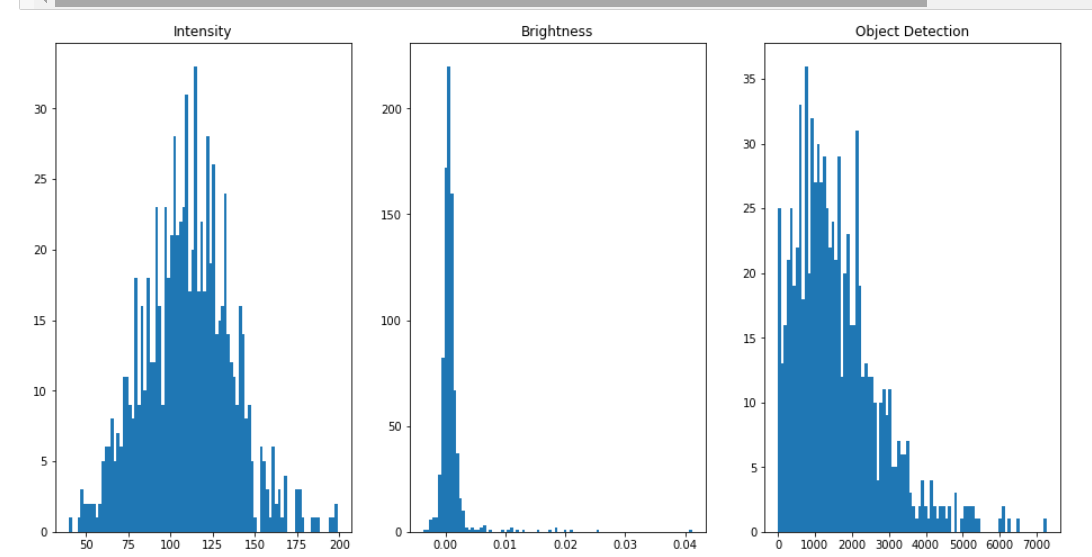
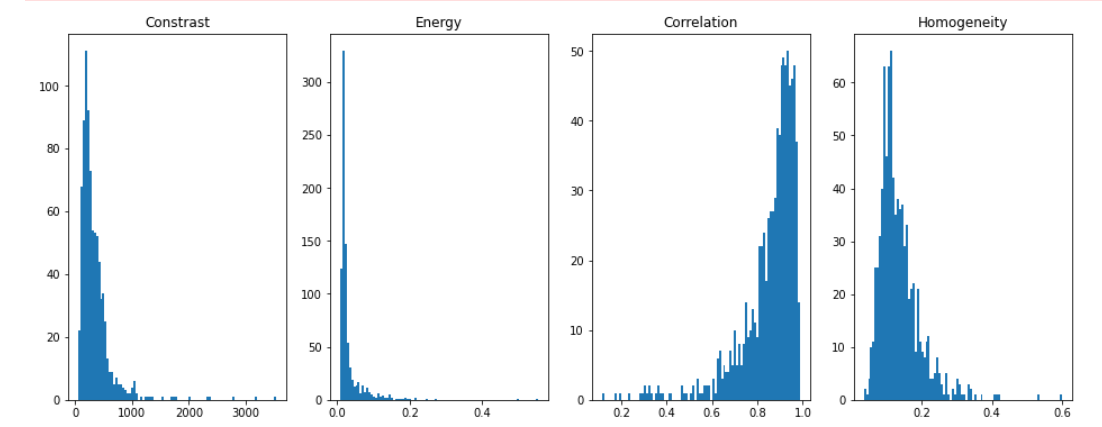

Taki kształt llub bardzo podobny mają wszystkie kategorie chorób.

Analiza powyższych wyników:

Intensywność: Średnia intensywność jest wartością od 0 (czarne) do 255 (białe). W naszych zdjęciach najwięcej jest wartości środkowych
Brightness: Do analizy różnic w jasności. W naszych zdjęciach jasność jest bardzo mała
Objects Detection: ilość wykrytych na obrazie obiektów. Na większości obrazów liczba obiektów jest mniejsza niż 2000

Kontrast: Dominacja niskich wartości kontrastu sugeruje, że większość obrazów ma raczej jednorodne intensywności pikseli.
Energia: Niskie wartości energii dla większości obrazów sugerują, że obrazy te są zróżnicowane teksturowo.
Korelacja: Wysokie wartości korelacji wskazują, że wiele obrazów ma piksele, które są silnie skorelowane, co może oznaczać pewien rodzaj regularności lub wzorca w obrazach.
Jednorodność: Średnie do wysokie wartości jednorodności sugerują, że w wielu obrazach piksele mają podobne intensywności, co prowadzi do mniejszych różnic między sąsiednimi pikselami

#### Wykorzystanie algorytmu Canny:

Algorytm Canny, używany do wykrywania konturów na obrazie, teoretycznie miał znaleźć więcej konturów w przypadku chorób trądzikowych.
W praktyce jednak okazało się, że zdjęcia starszych osób zawierają wiele linii i kształtów, niezależnie od choroby. Dodatkowo, tło oraz ułożenie skóry często generują wiele dodatkowych konturów, co nie przyczynia się do skutecznej identyfikacji chorób.
Wnioski:
Ze względu na różnorodność i specyfikę zdjęć, proces klasyfikacji chorób skóry jest skomplikowany.

## Image correction and first preprocessing

### Handling outliers

In [ ]:
# Code to get images excluding outliers

# Setting the path for dataest
#dataset_path = 'C:\\Users\\HP\\ML\\Dermnet\\train'

paths_to_images = dict()
outlier_images = [path.split('//')[-1] for path in list_of_outliers]

# Getting all image filenames from found directories excluding outliers
for directory in os.listdir(dataset_path):
    image_path = f'{dataset_path}//{directory}//'
    for img_file in os.listdir(f'{dataset_path}//{directory}'):
        if img_file not in outlier_images:
            if image_path in paths_to_images:
                paths_to_images[image_path].append(img_file)
            else:
                paths_to_images[image_path] = [img_file]       
# paths_to_images

### Changing size

In [ ]:
# target_size=(194, 128)
target_size = (128, 128)
images = []
for key in paths_to_images:
    for value in paths_to_images[key]:
        img = Image.open(f'{key}{value}')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
# images

### Example of image preprocessing before and after

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

img = Image.open(dataset_path + "//Scabies Lyme Disease and other Infestations and Bites//jelly-fish-sting2.jpg")
#img = Image.open('..//Data//train//Scabies Lyme Disease and other Infestations and Bites//jelly-fish-sting2.jpg')     
axes[0][0].imshow(img)
axes[0][0].axis('off')
img = img.resize(target_size)
img = np.array(img) / 255.0
axes[0][1].imshow(img)
axes[0][1].axis('off')

img = Image.open(dataset_path + "//Light Diseases and Disorders of Pigmentation//phototoxic-reactions-63.jpg")
#img = Image.open('..//Data//train//Light Diseases and Disorders of Pigmentation//phototoxic-reactions-63.jpg')      
axes[1][0].imshow(img)
axes[1][0].axis('off')
img = img.resize(target_size)
img = np.array(img) / 255.0
axes[1][1].imshow(img)
axes[1][1].axis('off')

plt.tight_layout()
plt.show()

## Conclusions

- Our business objective is finding and distinguishing different skin diseases. Pictures that don't depict these illnesses are classified as outliers and are excluded form further usage. Sense the goal of the project is to create a model that distinguishes images, the outliers had to be found manually.
- Images have different sizes. 
- The sizes are mostly the same, but the irientation varies.
- There is no clear way of knowing, how an image sould be oriented, e.g. pictures of a thumb with a nail can be found pointing all four directions.
- Images aren't square, so it's neccesseary to resize them.

In [ ]:
metrics_labels = ['Mean Intensity', 'Mean Brightness', 'Mean Objects', 'Mean Contrast', 'Mean Energy', 'Mean Correlation', 'Mean Homogeneity']
num_metrics = len(metrics_labels)
fig, axs = plt.subplots(num_metrics, 1, figsize=(15, num_metrics * 5))

for i in range(num_metrics):
    sorted_data = dict(sorted(analysis.items(), key=lambda item: item[1][i]))
    metric_values = [values[i] for values in sorted_data.values()]
    axs[i].bar(sorted_data.keys(), metric_values)
    axs[i].set_title(metrics_labels[i])
    axs[i].set_xticklabels(sorted_data.keys(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


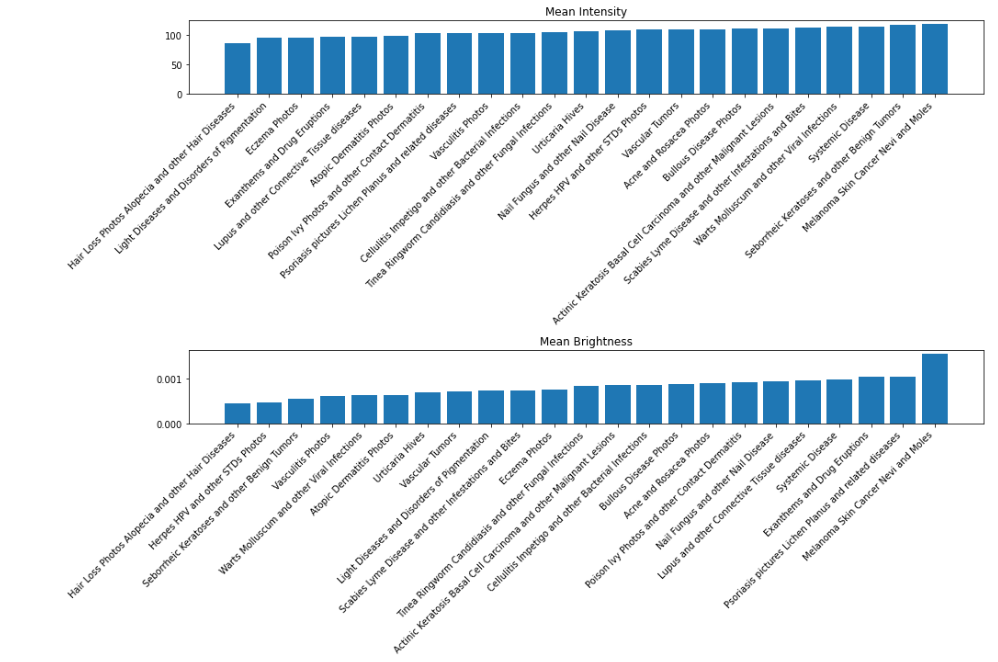
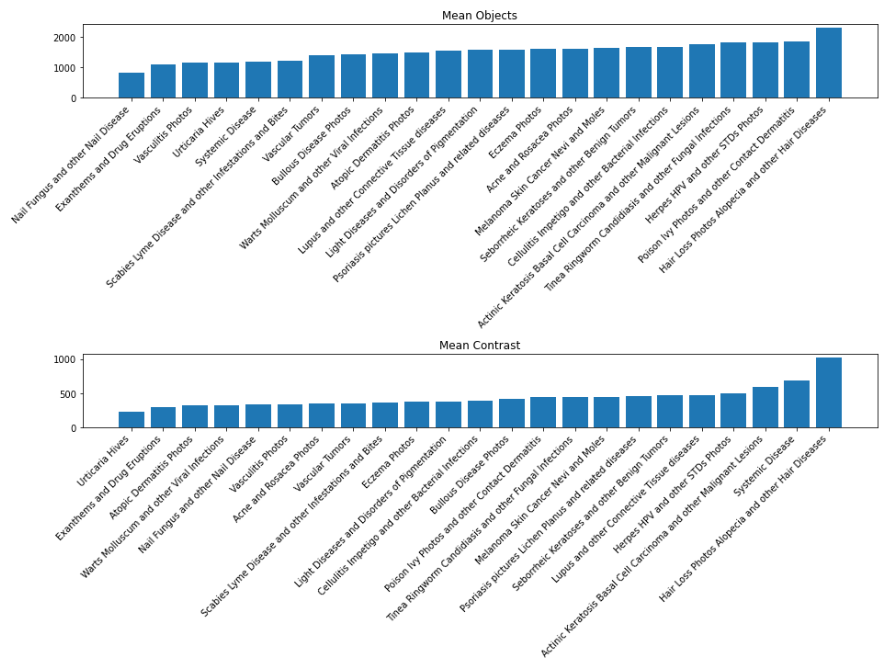
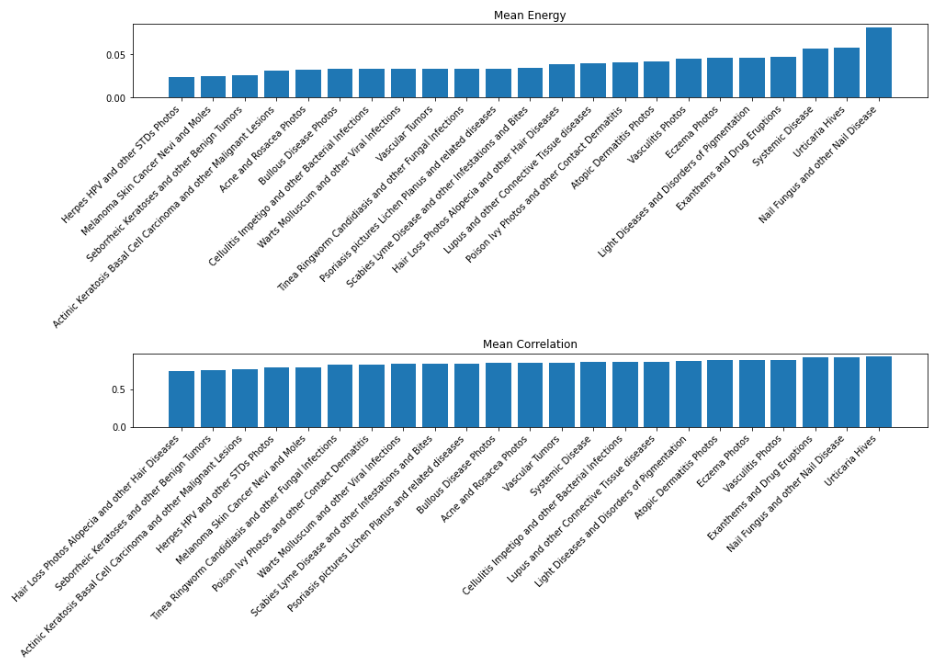
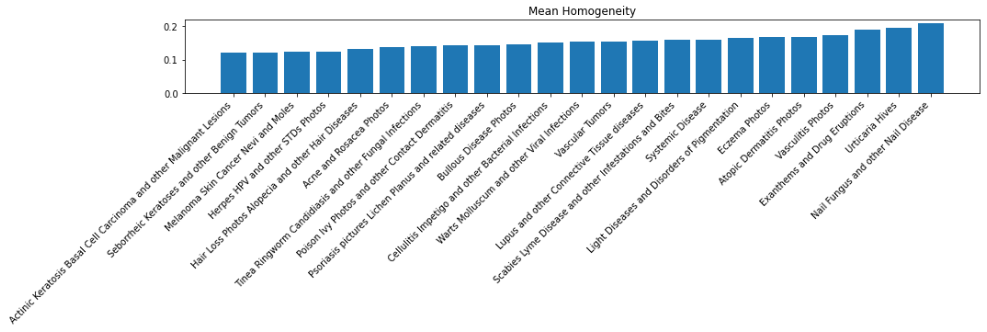

Mean Intensity (Średnia Intensywność):

Wszystkie kategorie mają zbliżoną średnią intensywność, co sugeruje, że kategorie są dość jednolite pod względem intensywności kolorów.
Niektóre kategorie, takie jak "Hair Loss Photos Alopecia and other Hair Diseases" oraz "Melanoma Skin Cancer Nevi and Moles", mają nieco wyższą intensywność.

Mean Brightness (Średnia Jasność):

Jasność w większości kategorii jest bardzo niska, prawie zerowa, co znaczy, że zdjęcia są ciemne lub mają niewiele jasnych obszarów.
Kategoria "Melanoma Skin Cancer Nevi and Moles" wyróżnia się nieco wyższą jasnością.

Mean Objects (Średnia Liczba Obiektów):

"Nail Fungus and other Nail Disease" ma znacznie mniejszą liczbę obiektów w porównaniu do innych kategorii.
Kategoria "Hair Loss Photos Alopecia and other Hair Diseases" ma największą liczbę obiektów, co znaczy, że te zdjęcia zawierają więcej szczegółów.

Mean Contrast (Średni Kontrast):

W większości kategorii kontrast jest zbliżony.
Kategoria "Hair Loss Photos Alopecia and other Hair Diseases" wykazuje znacznie wyższy kontrast, co sugeruje większe różnice pomiędzy najjaśniejszymi i najciemniejszymi obszarami na tych zdjęciach.

Mean Energy (Średnia Energia):

Energia jest bardzo niska w większości kategorii, co oznacza, że tekstura zdjęć jest raczej jednolita.
"Nail Fungus and other Nail Disease" ma nieco wyższą energię, co oznacza większą złożoność tekstury.

Mean Correlation (Średnia Korelacja):

Korelacja jest dość wysoka we wszystkich kategoriach, co sugeruje, że piksele na zdjęciach mają podobne wartości w ich najbliższym otoczeniu.
Najniższą korelację mają "Hair Loss Photos Alopecia and other Hair Diseases", ale różnice są niewielkie.